In [3]:
!pip install pmdarima
!pip install workalendar
!pip install prophet
!pip install -q --upgrade linear-tree
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=79d94b75d732c2c9a738434a9a79be49987d793aaffbfd846538b0c8cba230a0
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


In [4]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging
import pandas as pd


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

In [5]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [6]:
df = pd.read_csv("/content/historic_demand_2009_2024.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

**EDA**

In [ ]:
df.sample(n=7)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
58204       2012-04-27                 29  40645  41571                 36942   
23074       2010-04-26                 37  39601  40495                 36012   
36735       2011-02-05                 16  32765  33666                 29490   
34123       2010-12-12                 44  42091  43154                 37759   
2988        2009-03-04                 13  35842  39151                 32268   
208056      2020-11-13                 25  30583  31187                 28322   
70974       2013-01-18                 28  49607  51516                 45351   

        embedded_wind_generation  embedded_wind_capacity  \
58204                        341                    2019   
23074                        446                    1883   
36735                       1684                    1734   
34123                        288                    2141   
2988                         754                    1419   
208056                      2520                    6527   
70974                       1207                    2085   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
58204                         383                     1468            0  ...   
23074                           1                       20            0  ...   
36735                           0                       96            0  ...   
34123                           0                       72            0  ...   
2988                            0                        0            0  ...   
208056                       3820                    13080            0  ...   
70974                         131                     2077            0  ...   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
58204           0           994        -412               0          0   
23074           0             0        -390               0          0   
36735           0             0        -290               0          0   
34123           0             0        -450               0          0   
2988            0             0         -94               0          0   
208056          0           916          85             225        999   
70974           0           738        -251            -250          0   

        nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday  
58204        NaN            NaN                NaN          NaN           0  
23074        NaN            NaN                NaN          NaN           0  
36735        NaN            NaN                NaN          NaN           0  
34123        NaN            NaN                NaN          NaN           0  
2988         NaN            NaN                NaN          NaN           0  
208056       0.0            0.0                NaN          NaN           0  
70974        NaN            NaN                NaN          NaN           0  

[7 rows x 22 columns]

In [7]:
df.describe()

settlement_period             nd            tsd  england_wales_demand  \
count      263808.000000  263808.000000  263808.000000         263808.000000   
mean           24.500227   31510.256152   32924.728450          28670.783126   
std            13.853819    7819.611741    7724.956571           7086.475517   
min             1.000000   13367.000000       0.000000              0.000000   
25%            12.750000   25252.000000   26898.000000          22977.000000   
50%            24.500000   30890.000000   32124.000000          28101.000000   
75%            36.250000   37263.000000   38428.000000          33928.000000   
max            50.000000   59095.000000   60147.000000          53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             263808.000000           263808.000000   
mean                1235.034620             4322.747809   
std                  938.852117             1942.415441   
min                    0.000000             1403.000000   
25%                  536.000000             2087.000000   
50%                  990.000000             4260.000000   
75%                 1678.000000             6488.000000   
max                 5539.000000             6574.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              263808.000000            263808.000000  263808.000000   
mean                  830.113636              8190.460323       7.044078   
std                  1639.247554              5667.455563      40.247241   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              1919.000000       0.000000   
50%                     0.000000             10500.000000       0.000000   
75%                   793.000000             13080.000000       0.000000   
max                  9830.000000             15954.000000     893.000000   

       pump_storage_pumping  ...      ifa2_flow   britned_flow     moyle_flow  \
count         263808.000000  ...  263808.000000  263808.000000  263808.000000   
mean             311.670491  ...      27.168035     522.931871    -116.397971   
std              536.481615  ...     326.437351     525.620201     226.911549   
min                0.000000  ...   -1030.000000   -1215.000000    -505.000000   
25%                8.000000  ...       0.000000       0.000000    -271.000000   
50%               11.000000  ...       0.000000     750.000000    -134.000000   
75%              399.000000  ...       0.000000     994.000000      36.000000   
max             2019.000000  ...    1016.000000    1143.000000     499.000000   

       east_west_flow      nemo_flow      nsl_flow  eleclink_flow  \
count   263808.000000  263808.000000  88512.000000   88512.000000   
mean       -35.816927     157.112146    292.368865      20.569855   
std        255.361825     402.109977    583.987247     433.520021   
min       -585.000000   -1022.000000  -1455.000000   -1028.000000   
25%       -162.000000       0.000000      0.000000       0.000000   
50%          0.000000       0.000000      0.000000       0.000000   
75%          0.000000      46.000000    693.000000       0.000000   
max        504.000000    1033.000000   1401.000000    1002.000000   

       scottish_transfer   viking_flow     is_holiday  
count       18384.000000  18384.000000  263808.000000  
mean         1576.125000     14.438969       0.022926  
std          1802.590195    153.475925       0.149667  
min         -2851.000000  -1465.000000       0.000000  
25%           172.000000      0.000000       0.000000  
50%          1415.500000      0.000000       0.000000  
75%          2867.250000      0.000000       0.000000  
max          6238.000000   1408.000000       1.000000  

[8 rows x 21 columns]

In [8]:
df.shape

(263808, 22)

In [9]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [10]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
scottish_transfer             True
viking_flow                   True
is_holiday                   False
dtype: bool

In [11]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

nsl_flow  eleclink_flow
True     175296         175296
False     88512          88512

In [12]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
0           2009-01-01                  1  37910  38704                 33939   
1           2009-01-01                  2  38047  38964                 34072   
2           2009-01-01                  3  37380  38651                 33615   
3           2009-01-01                  4  36426  37775                 32526   
4           2009-01-01                  5  35687  37298                 31877   
...                ...                ...    ...    ...                   ...   
175291      2018-12-31                 44  26826  28428                 25195   
175292      2018-12-31                 45  25660  27542                 24145   
175293      2018-12-31                 46  25047  26971                 23496   
175294      2018-12-31                 47  24188  26224                 22683   
175295      2018-12-31                 48  23800  25785                 22367   

        embedded_wind_generation  embedded_wind_capacity  \
0                             54                    1403   
1                             53                    1403   
2                             53                    1403   
3                             50                    1403   
4                             50                    1403   
...                          ...                     ...   
175291                      2734                    5918   
175292                      2730                    5918   
175293                      2726                    5918   
175294                      2673                    5918   
175295                      2620                    5918   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
0                               0                        0            0  ...   
1                               0                        0            0  ...   
2                               0                        0            0  ...   
3                               0                        0            0  ...   
4                               0                        0            0  ...   
...                           ...                      ...          ...  ...   
175291                          0                    13052            0  ...   
175292                          0                    13052            0  ...   
175293                          0                    13052            0  ...   
175294                          0                    13052            0  ...   
175295                          0                    13052            0  ...   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
0               0             0        -161               0          0   
1               0             0        -160               0          0   
2               0             0        -160               0          0   
3               0             0        -160               0          0   
4               0             0        -160               0          0   
...           ...           ...         ...             ...        ...   
175291          0           777        -454            -535          0   
175292          0          -268        -455            -536          0   
175293          0          -297        -455            -536          0   
175294          0          -467        -454            -466          0   
175295          0          -453        -454            -381          0   

        nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday  
0            NaN            NaN                NaN          NaN           1  
1            NaN            NaN                NaN          NaN           1  
2            NaN            NaN                NaN          NaN           1  
3            NaN            NaN                NaN          NaN           1  
4            NaN            NaN                NaN          NaN          

In [13]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [14]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [15]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

In [16]:
print(type(holiday_dates_observed))
print(holiday_dates_observed[:3])

<class 'list'>
[numpy.datetime64('2009-01-01'), numpy.datetime64('2009-04-10'), numpy.datetime64('2009-04-13')]


In [17]:
holiday_dates_observed = pd.Series(holiday_dates_observed)

In [18]:
df["is_holiday"] = df["settlement_date"].apply(
lambda x: pd.to_datetime(x) in holiday_dates_observed.dt.date
)

In [19]:
df["is_holiday"] = df["is_holiday"].astype(int)

In [20]:
df[df["is_holiday"] == 1].shape[0]

0

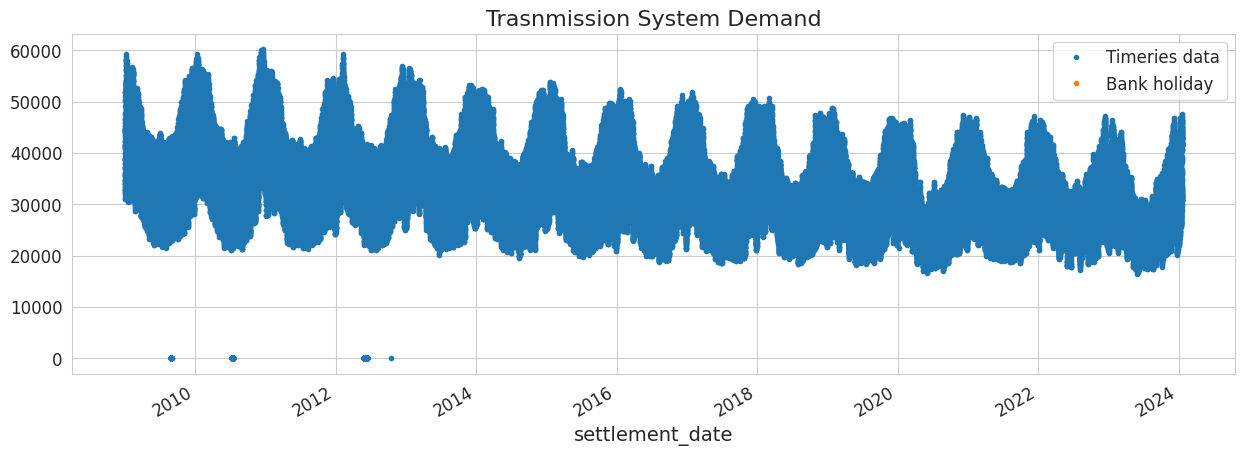

In [21]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

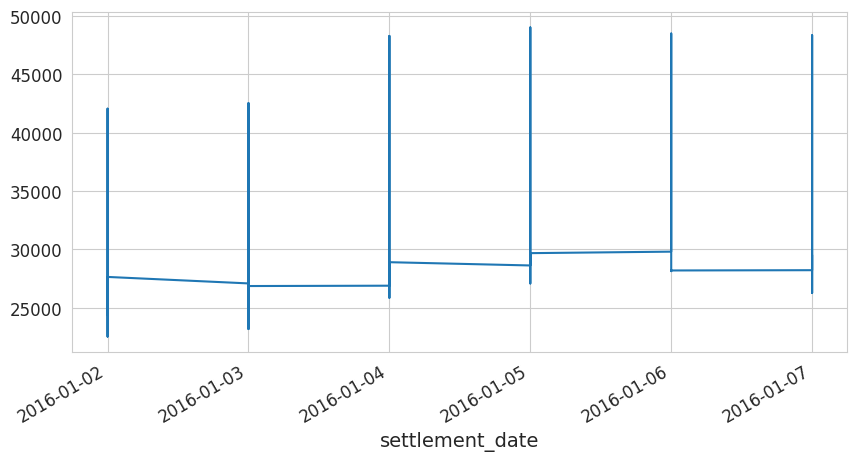

In [22]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

In [23]:
df_plot.head()

settlement_period     nd    tsd  england_wales_demand  \
settlement_date                                                          
2009-01-01                       1  37910  38704                 33939   
2009-01-01                       2  38047  38964                 34072   
2009-01-01                       3  37380  38651                 33615   
2009-01-01                       4  36426  37775                 32526   
2009-01-01                       5  35687  37298                 31877   

                 embedded_wind_generation  embedded_wind_capacity  \
settlement_date                                                     
2009-01-01                             54                    1403   
2009-01-01                             53                    1403   
2009-01-01                             53                    1403   
2009-01-01                             50                    1403   
2009-01-01                             50                    1403   

                 embedded_solar_generation  embedded_solar_capacity  \
settlement_date                                                       
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   

                 non_bm_stor  pump_storage_pumping  ifa_flow  ifa2_flow  \
settlement_date                                                           
2009-01-01                 0                    33      2002          0   
2009-01-01                 0                   157      2002          0   
2009-01-01                 0                   511      2002          0   
2009-01-01                 0                   589      1772          0   
2009-01-01                 0                   851      1753          0   

                 britned_flow  moyle_flow  east_west_flow  nemo_flow  \
settlement_date                                                        
2009-01-01                  0        -161               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   

                 scottish_transfer  viking_flow  is_holiday  
settlement_date                                              
2009-01-01                     NaN          NaN           0  
2009-01-01                     NaN          NaN           0  
2009-01-01                     NaN          NaN           0  
2009-01-01                     NaN          NaN           0  
2009-01-01                     NaN          NaN           0

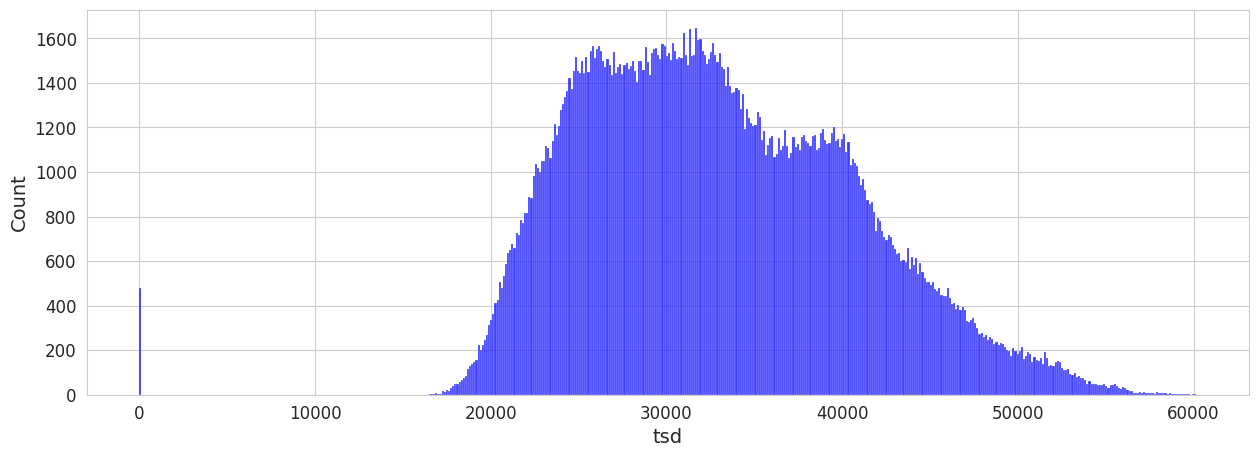

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

In [25]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [26]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

settlement_date  settlement_period period_hour     nd    tsd  \
252196      2023-06-06                 35    17:00:00  26609  27853   
65700       2012-10-15                 45    22:00:00  34877  35641   
101820      2014-11-07                 25    12:00:00  40041  41206   
3091        2009-03-06                 20     9:30:00  45968  47719   
134793      2016-09-24                 26    12:30:00  24699  25301   
33529       2010-12-06                 30    14:30:00  52446  53453   
221821      2021-09-11                 40    19:30:00  28571  29351   

        england_wales_demand  embedded_wind_generation  \
252196                 23958                      1137   
65700                  31512                       456   
101820                 36301                      1299   
3091                   41687                       281   
134793                 22683                      3062   
33529                  47597                        32   
221821                 25958                      1401   

        embedded_wind_capacity  embedded_solar_generation  \
252196                    6538                       3182   
65700                     2085                          0   
101820                    3939                       1140   
3091                      1419                          0   
134793                    4649                       4180   
33529                     2141                          4   
221821                    6527                          2   

        embedded_solar_capacity  ...  pump_storage_pumping  ifa_flow  \
252196                    15544  ...                     7       484   
65700                      1939  ...                    10        -3   
101820                     5627  ...                    19      1996   
3091                          0  ...                     8      -820   
134793                    11433  ...                     9       720   
33529                        70  ...                     6      1393   
221821                    13080  ...                    16       998   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
252196        444           647        -451            -286        455   
65700           0           994        -251               0          0   
101820          0           990        -149            -405          0   
3091            0             0        -323               0          0   
134793          0           880         -93               0          0   
33529           0             0        -401               0          0   
221821        992           912        -263               0          0   

        scottish_transfer  viking_flow  is_holiday  
252196            -1248.0          0.0           0  
65700                 NaN          NaN           0  
101820                NaN          NaN           0  
3091                  NaN          NaN           0  
134793                NaN          NaN           0  
33529                 NaN          NaN           0  
221821                NaN          NaN           0  

[7 rows x 21 columns]

In [27]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

settlement_date  settlement_period period_hour     nd    tsd  \
245349 2023-01-15 00:30:00                  2     0:30:00  21917  26640   
181902 2019-06-03 02:00:00                  5     2:00:00  17268  20232   
29566  2010-09-15 01:00:00                  3     1:00:00  23495  25557   
8166   2009-06-20 04:00:00                  9     4:00:00  21933  24083   
15673  2009-11-25 13:30:00                 28    13:30:00  43571  46606   

        england_wales_demand  embedded_wind_generation  \
245349                 20879                      4588   
181902                 16452                      3058   
29566                  21032                      1713   
8166                   19796                       614   
15673                  39178                      1673   

        embedded_wind_capacity  embedded_solar_generation  \
245349                    6545                          0   
181902                    6137                          0   
29566                     2092                          0   
8166                      1717                          0   
15673                     1740                          0   

        embedded_solar_capacity  ...  pump_storage_pumping  ifa_flow  \
245349                    15036  ...                  1270      -289   
181902                    13080  ...                   315      -972   
29566                        47  ...                  1455      1993   
8166                          0  ...                  1424      1342   
15673                         0  ...                     5     -2000   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
245349       -143          -813          -2               0       -562   
181902          0          -496          88             504       -681   
29566           0             0        -107               0          0   
8166            0             0        -226               0          0   
15673           0             0        -430               0          0   

        scottish_transfer  viking_flow  is_holiday  
245349             5444.0          0.0           0  
181902                NaN          NaN           0  
29566                 NaN          NaN           0  
8166                  NaN          NaN           0  
15673                 NaN          NaN           0  

[5 rows x 21 columns]

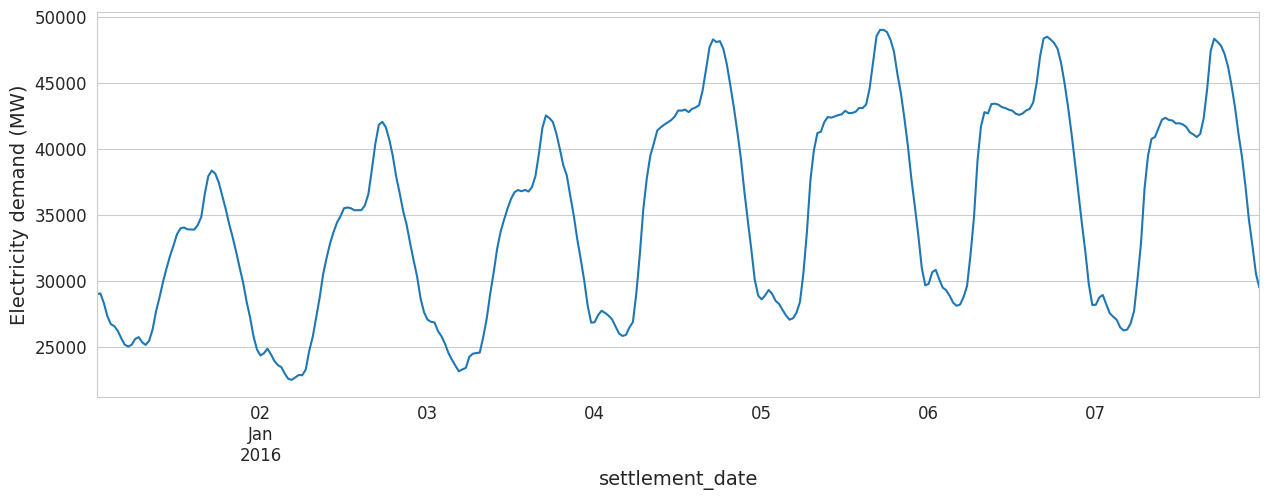

In [28]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [57]:
def create_features(df):

    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):

    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [30]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2019-04-21 23:30:00                 48    23:30:00  21307  21818   
2024-01-14 17:00:00                 35    17:00:00  40529  42120   
2009-07-27 15:00:00                 31    15:00:00  37945  38860   
2011-11-26 06:30:00                 14     6:30:00  28663  30984   
2016-03-21 17:00:00                 35    17:00:00  42541  43169   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2019-04-21 23:30:00                 19576                      1453   
2024-01-14 17:00:00                 37158                      2005   
2009-07-27 15:00:00                 34645                       729   
2011-11-26 06:30:00                 25962                      1232   
2016-03-21 17:00:00                 38941                       862   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2019-04-21 23:30:00                    6122                          0   
2024-01-14 17:00:00                    6488                          0   
2009-07-27 15:00:00                    1725                          0   
2011-11-26 06:30:00                    1845                          0   
2016-03-21 17:00:00                    4210                        425   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_month  \
settlement_date                                            ...                 
2019-04-21 23:30:00                    13080            0  ...            21   
2024-01-14 17:00:00                    15905            0  ...            14   
2009-07-27 15:00:00                        0            0  ...            27   
2011-11-26 06:30:00                     1062            0  ...            26   
2016-03-21 17:00:00                     9300            0  ...            21   

                     day_of_week  day_of_year  quarter  month  year  \
settlement_date                                                       
2019-04-21 23:30:00            6          111        2      4  2019   
2024-01-14 17:00:00            6           14        1      1  2024   
2009-07-27 15:00:00            0          208        3      7  2009   
2011-11-26 06:30:00            5          330        4     11  2011   
2016-03-21 17:00:00            0           81        1      3  2016   

                     week_of_year     lag1     lag2     lag3  
settlement_date                                               
2019-04-21 23:30:00            16  21908.0  22888.0  25724.0  
2024-01-14 17:00:00             2  39844.0  41622.0  42168.0  
2009-07-27 15:00:00            31      NaN      NaN      NaN  
2011-11-26 06:30:00            47  35514.0  31830.0      NaN  
2016-03-21 17:00:00            12  44615.0  43516.0  50980.0  

[5 rows x 30 columns]

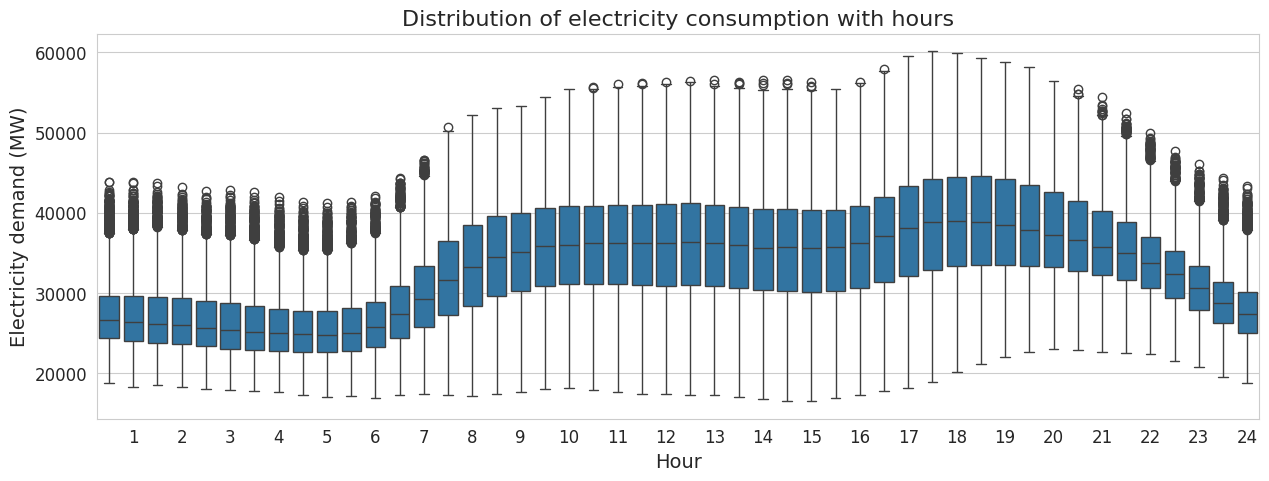

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

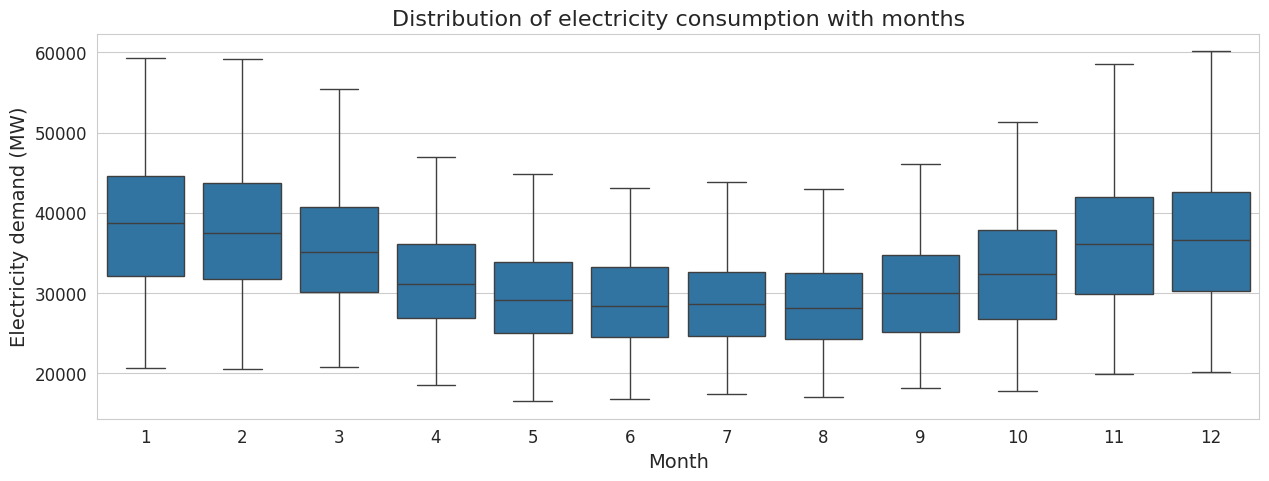

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

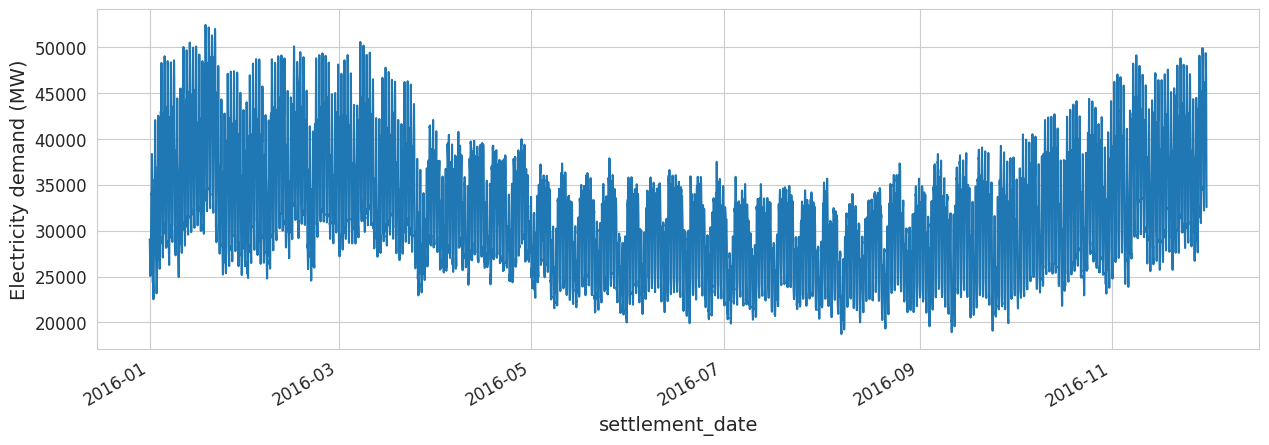

In [33]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

<ipython-input-34-a43933627e79>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


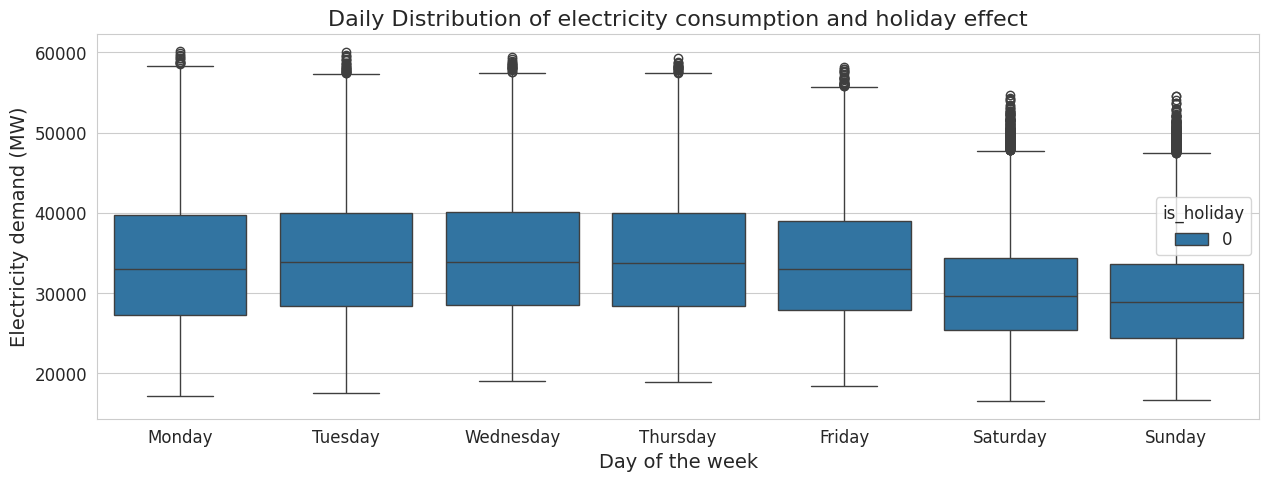

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

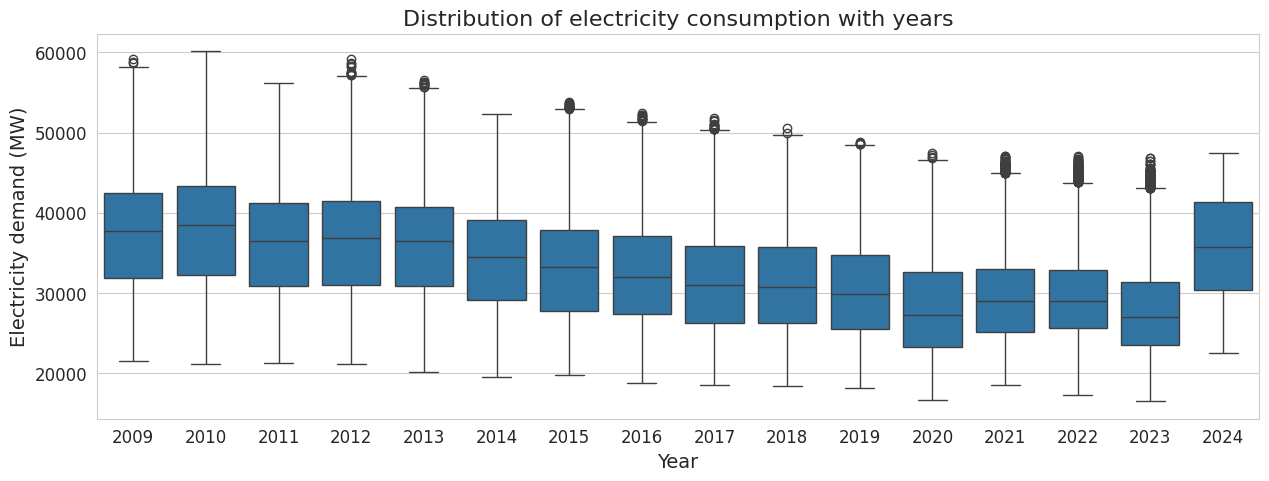

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

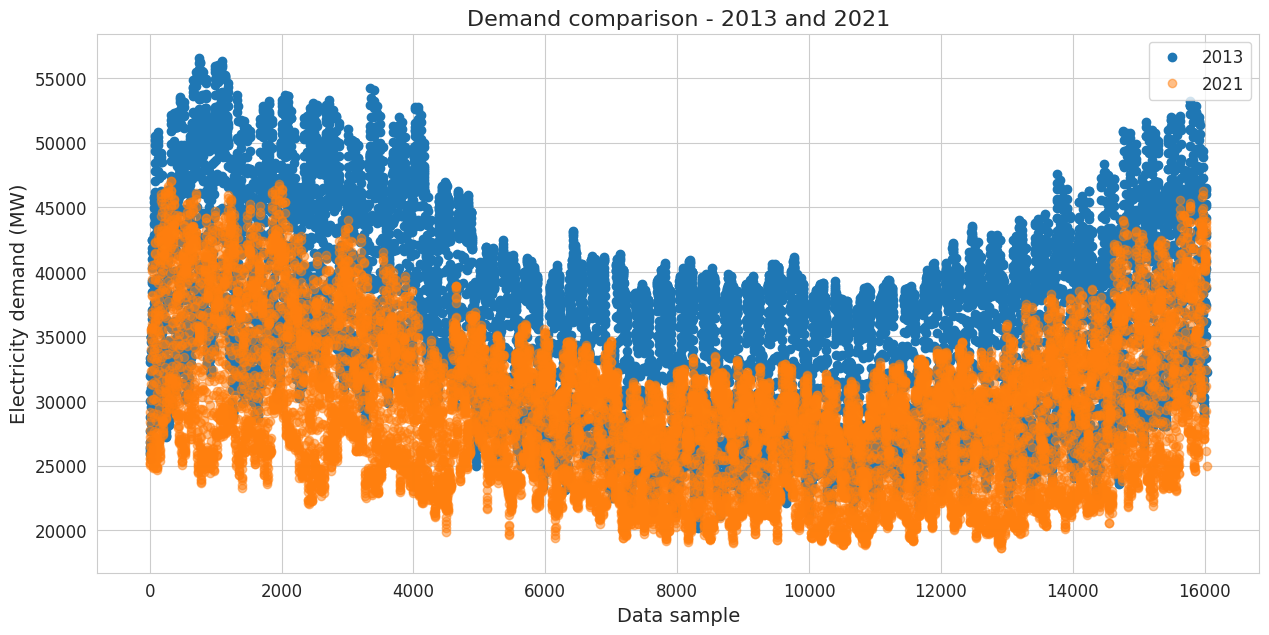

In [36]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

In [37]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

**SARIMA**

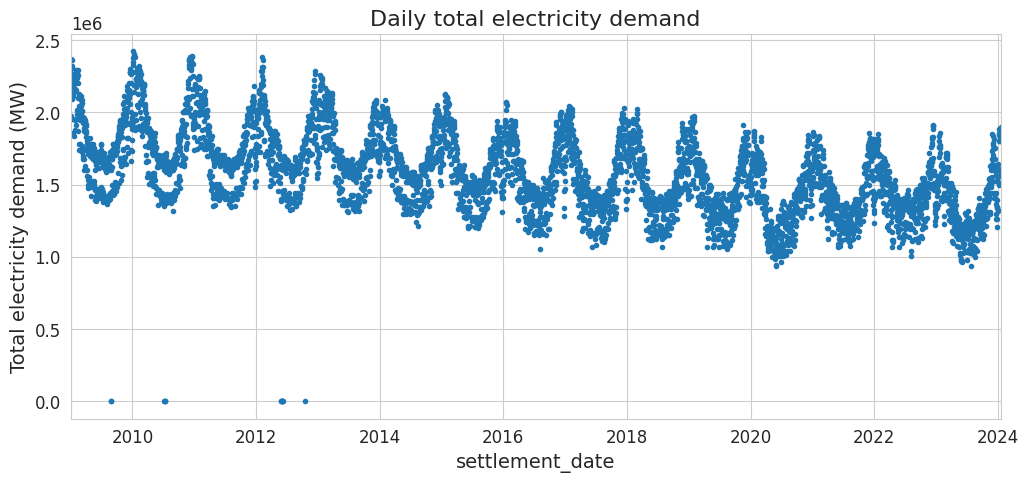

In [38]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

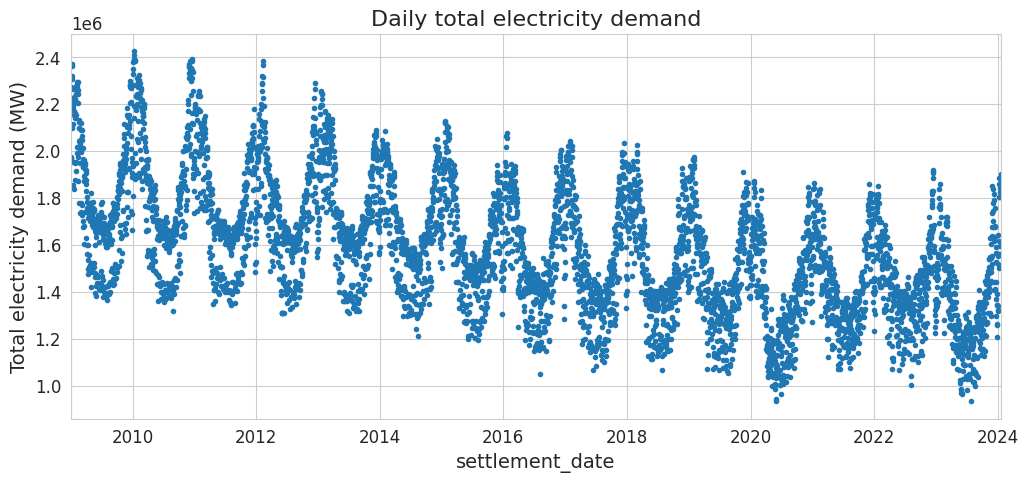

In [39]:
null_info = zip(
    df_sarima.loc[null_days].index.month, df_sarima.loc[null_days].index.year
)

mean_values = [
    df_sarima.loc[
        (df_sarima["month"] == info[0]) & (df_sarima["year"] == info[1]), "tsd"
    ].mean()
    for info in null_info
]

df_sarima.loc[null_days, "tsd"] = mean_values

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

In [40]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]

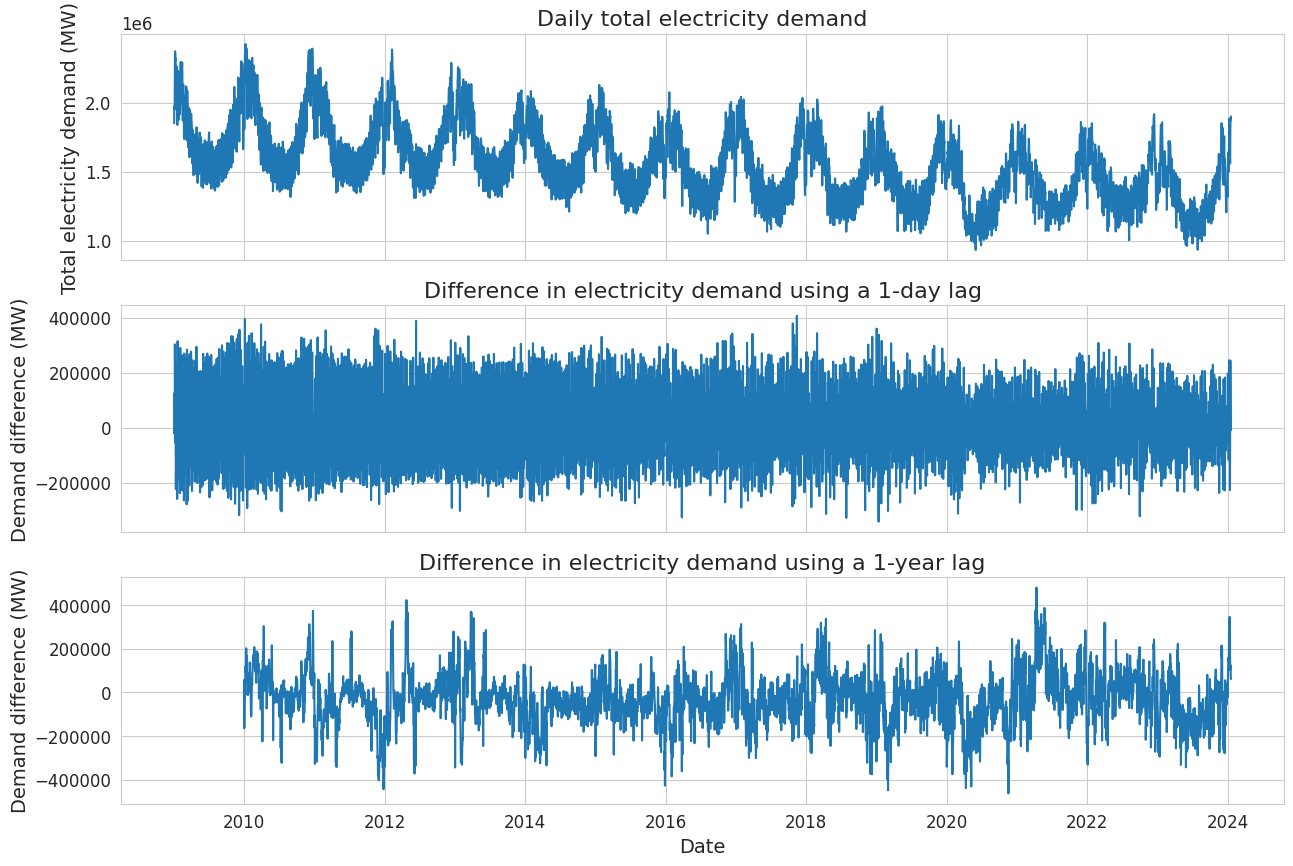

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes.ravel()
axes[0].plot(df_sarima.index, df_sarima["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")
axes[1].plot(df_sarima.index, df_sarima["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")
axes[2].plot(df_sarima.index, df_sarima["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag");

In [54]:
def dftest(timeseries, window_size):
    """
    Perform ADFuller test, report the results and plot rolling statistics

    Args:
        - timeseries: time series data
        - window_size: window size for rolling statistics
    """
    dftest = sm.stattools.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(data, lags=None):

    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()


def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):

    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

Test Statistic            -3.814837
p-value                    0.002759
Lags Used                 33.000000
Observations Used       5462.000000
Critical Value (1%)       -3.431548
Critical Value (5%)       -2.862069
Critical Value (10%)      -2.567052
dtype: float64


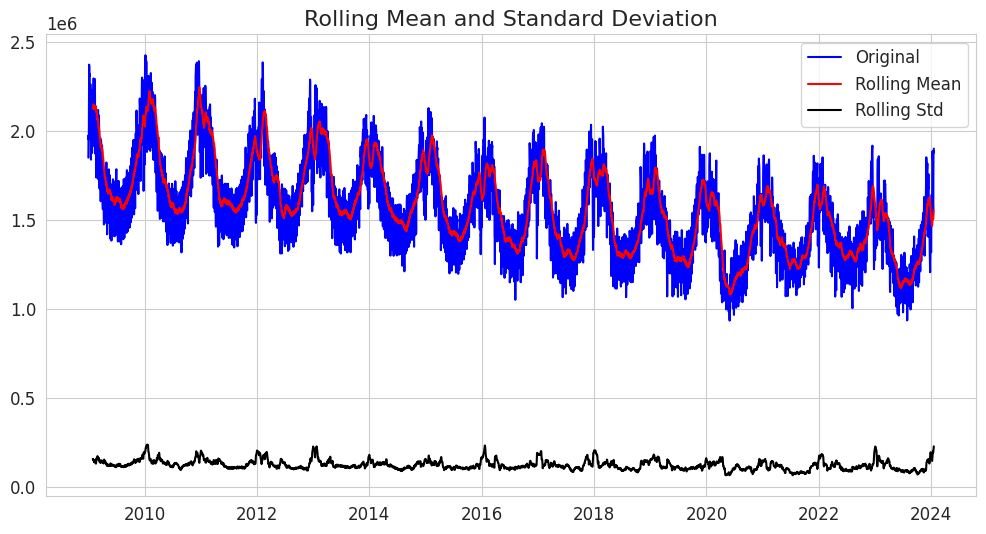

In [43]:
dftest(df_sarima["tsd"], 30)

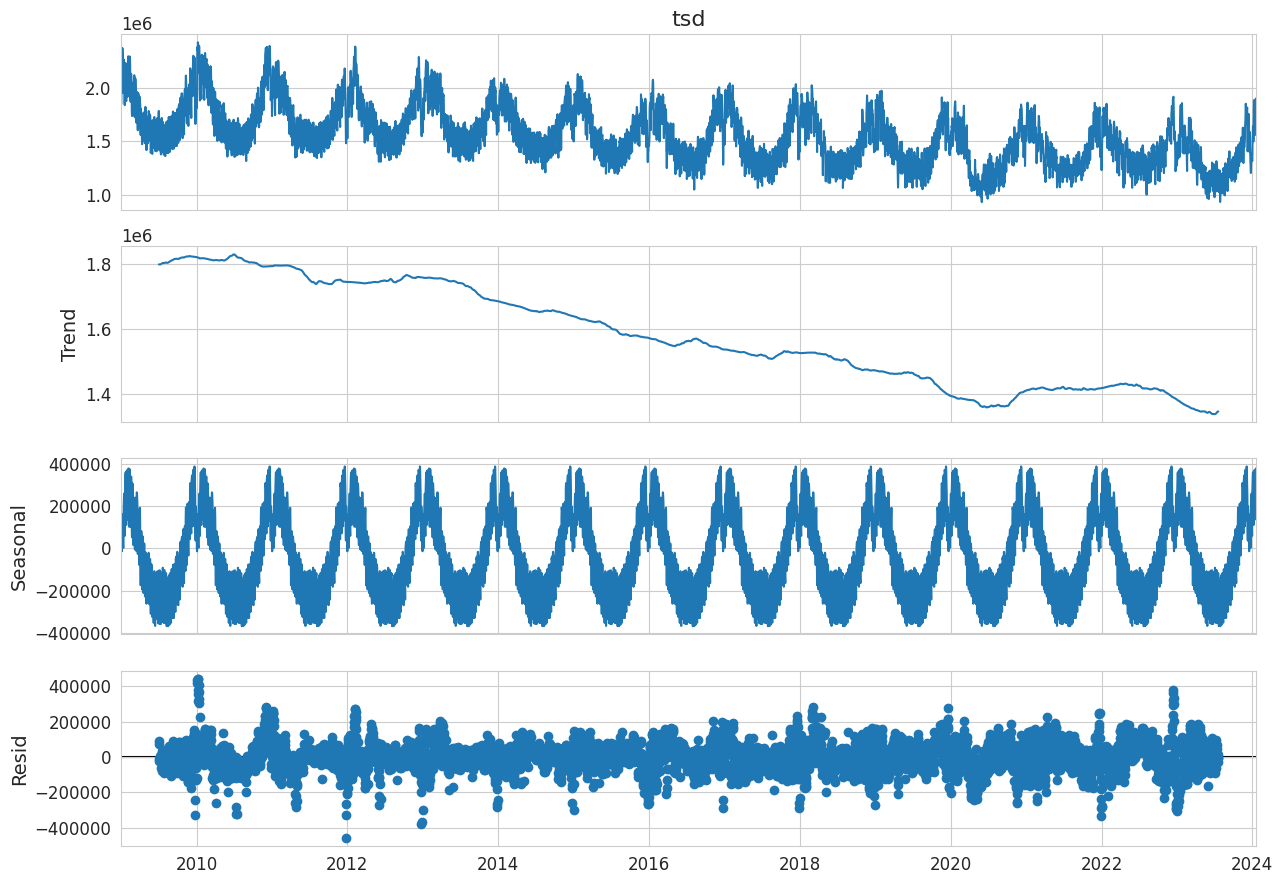

In [44]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

Test Statistic            -5.167697
p-value                    0.000010
Lags Used                 33.000000
Observations Used       5462.000000
Critical Value (1%)       -3.431548
Critical Value (5%)       -2.862069
Critical Value (10%)      -2.567052
dtype: float64


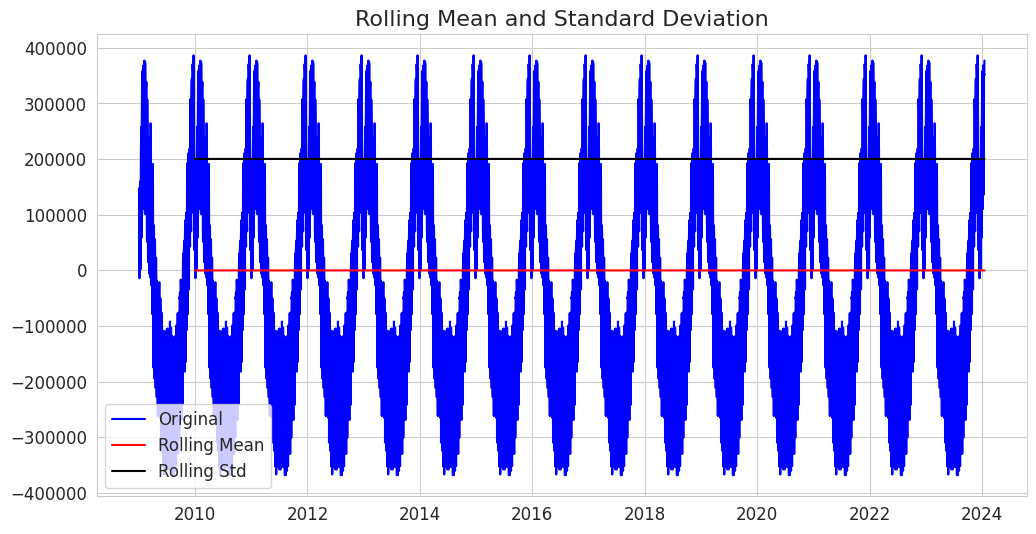

In [45]:
dftest(decompose.seasonal, 364)

Test Statistic         -8.772341e+00
p-value                 2.501384e-14
Lags Used               2.100000e+01
Observations Used       5.110000e+03
Critical Value (1%)    -3.431630e+00
Critical Value (5%)    -2.862106e+00
Critical Value (10%)   -2.567071e+00
dtype: float64


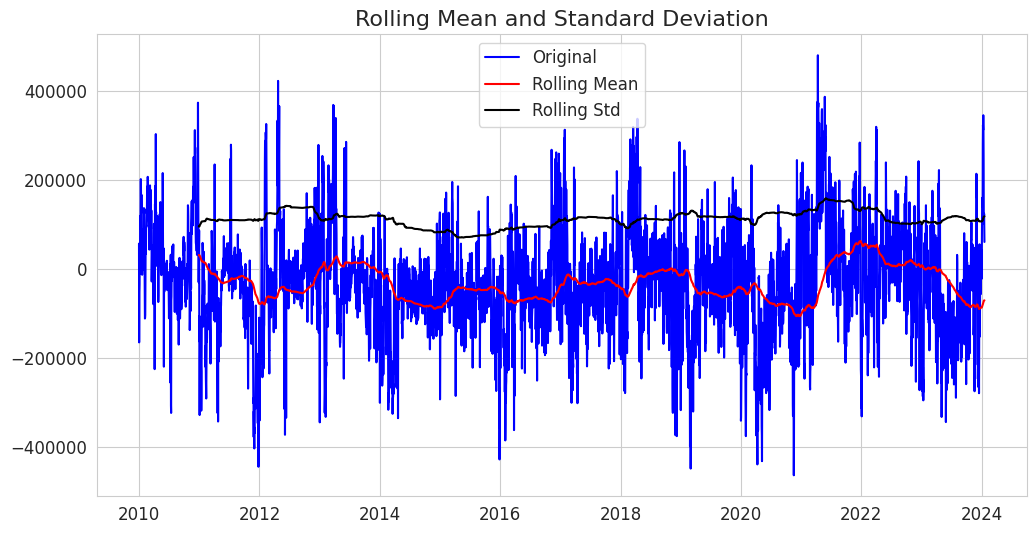

In [46]:
dftest(df_sarima["difference_year"].dropna(), 364)

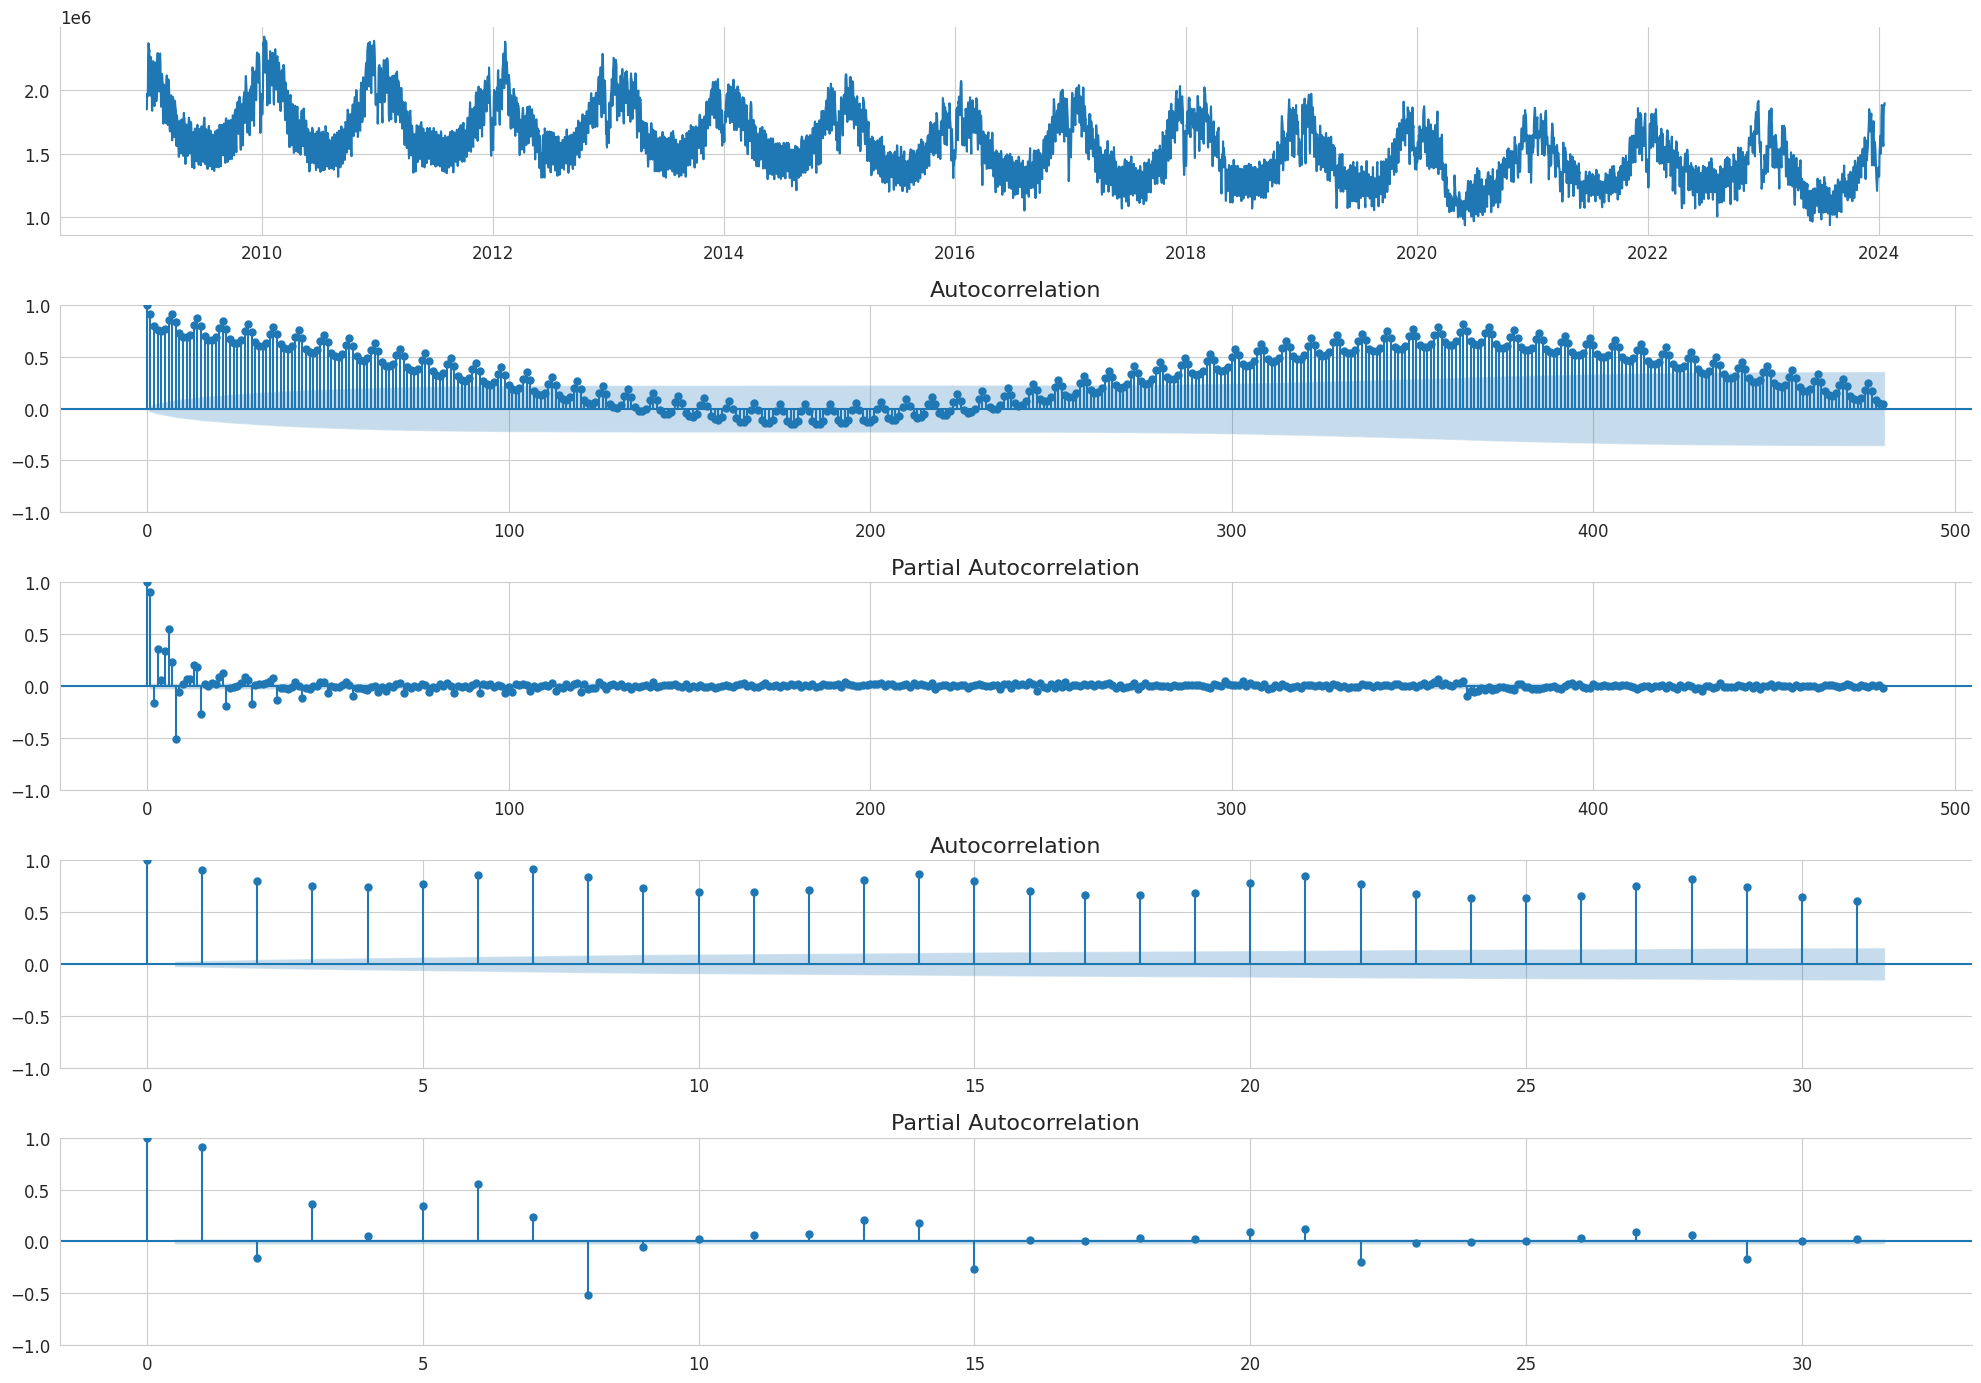

In [47]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)

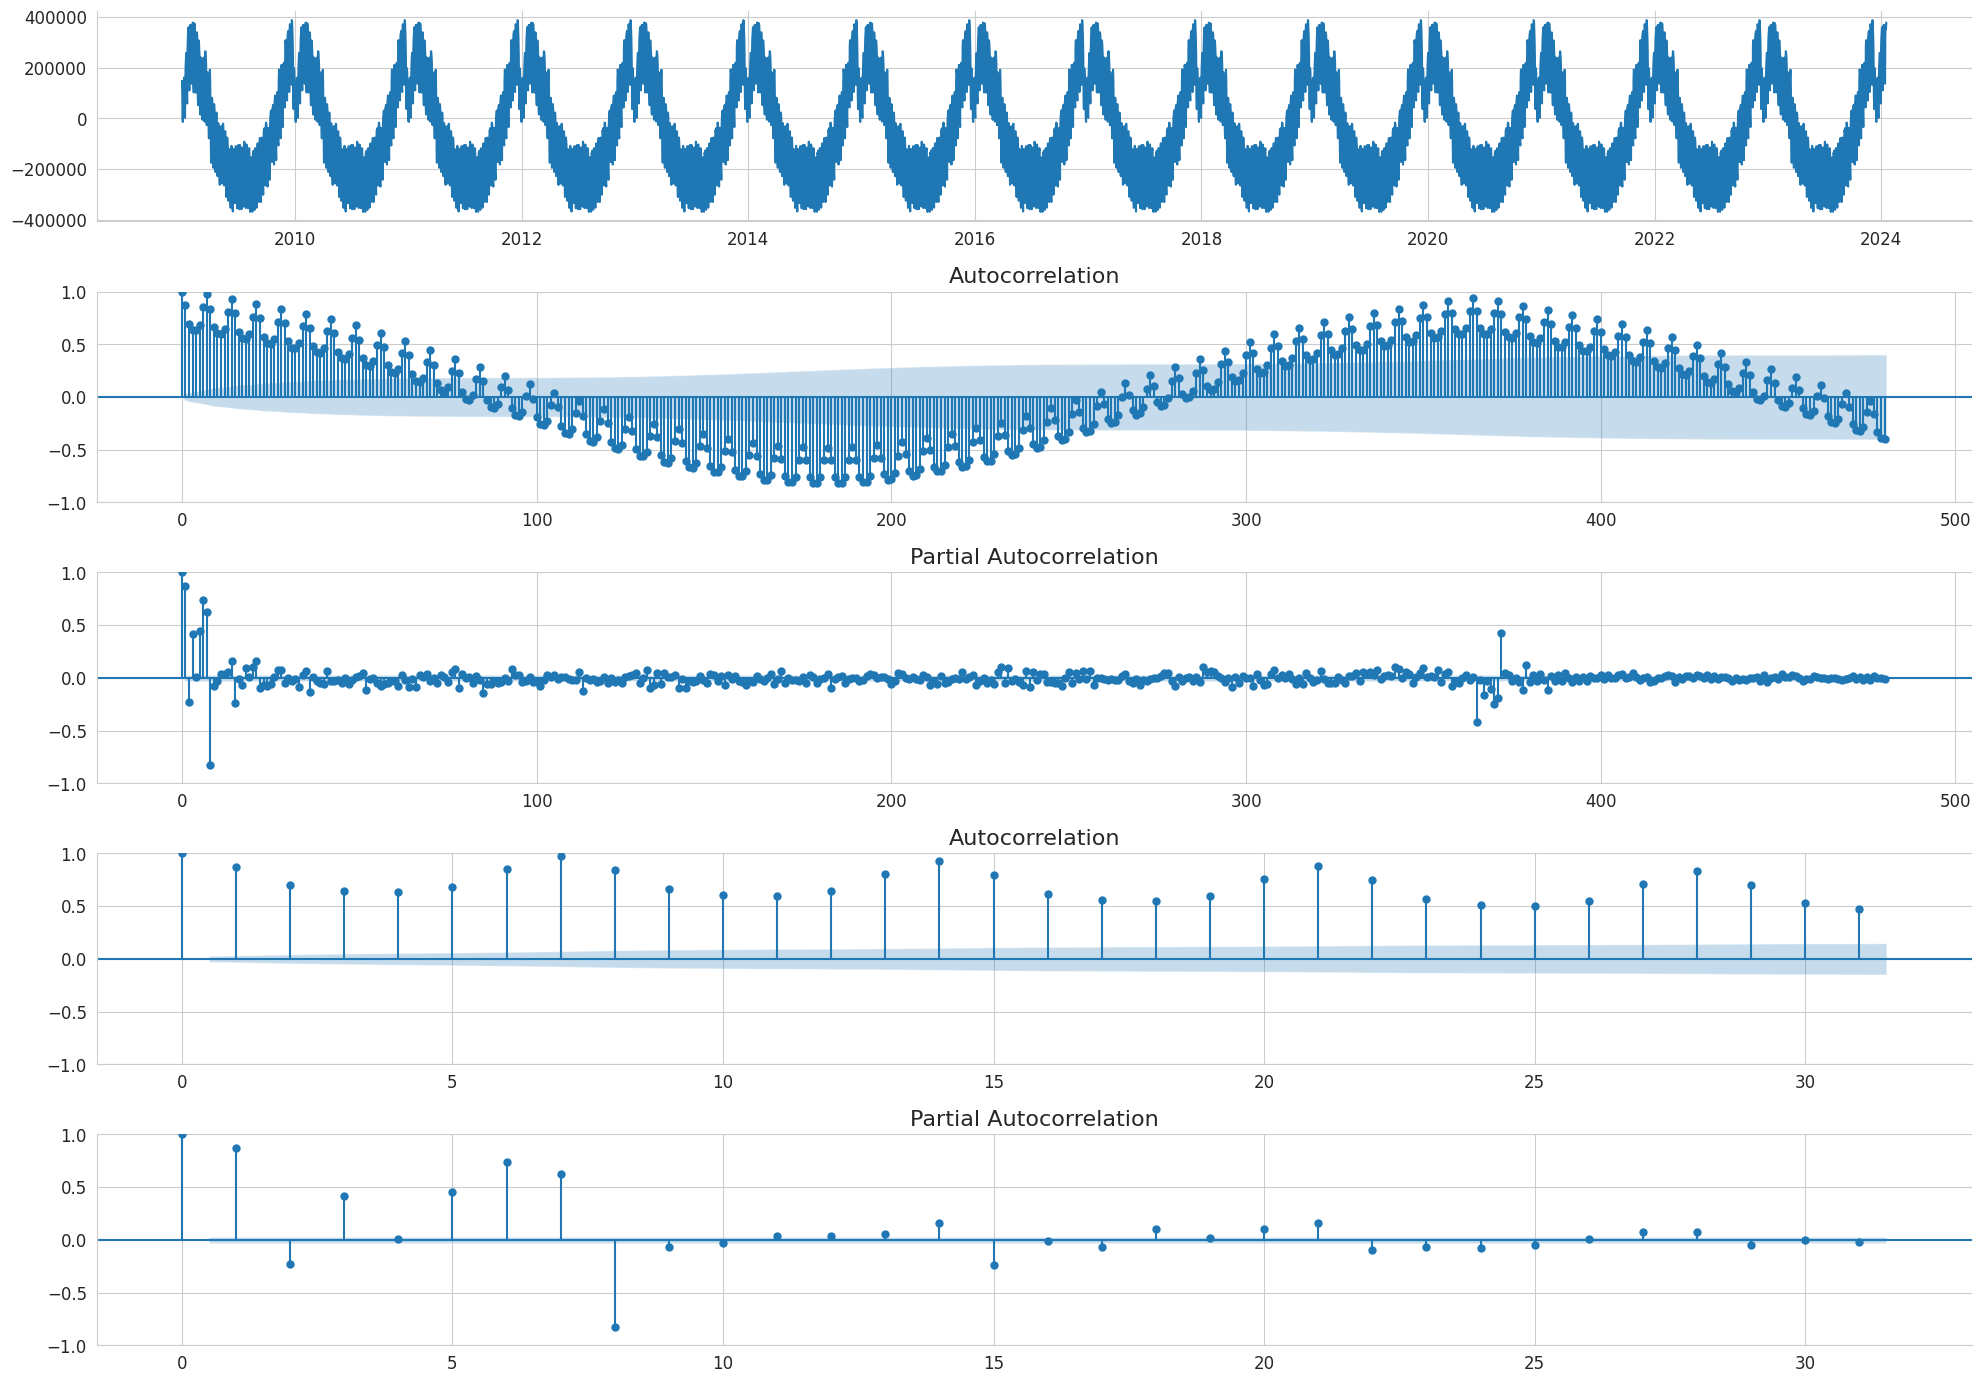

In [48]:
autocorr_plots_dual_lags(decompose.seasonal, lags_1=480, lags_2=31)

In [49]:
threshold_date = "01-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

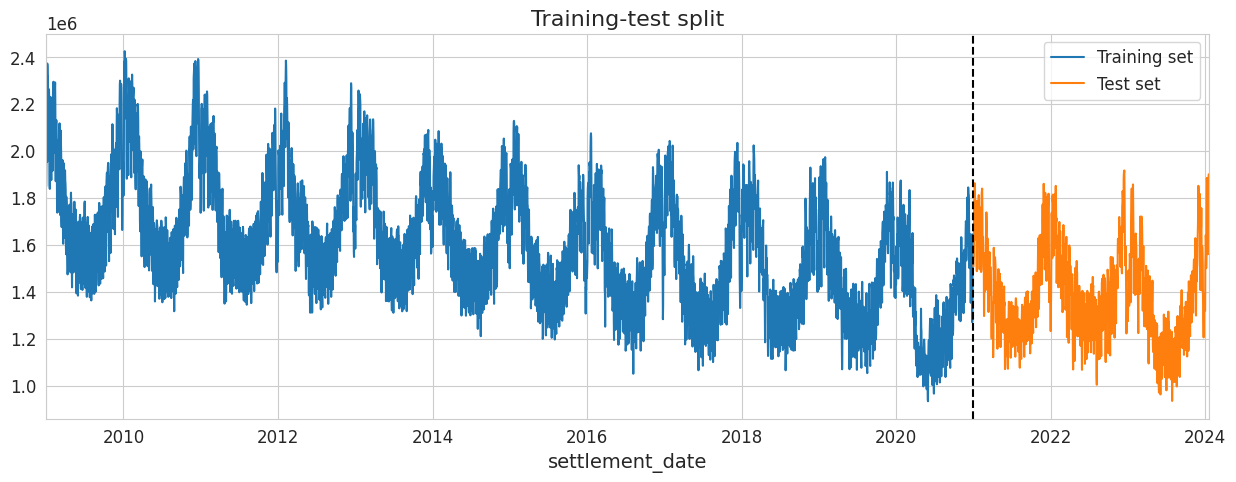

In [50]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

In [52]:
def stats_test(sar_model):

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = statsmodels.stats.stattools.durbin_watson(
        sar_model.filter_results.standardized_forecasts_error[
            0, sar_model.loglikelihood_burn :
        ]
    )

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("Durbin-Watson: d={:.2f}".format(durbin_watson))


def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):

    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # Predict on test data
    predict = sarima_model.get_prediction(
        start="01-01-2021", end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    return execution_time, mape, sarima_model

Normality: val=1086.819, p=0.000
Ljung-Box: val=7216.653, p=0.000
Heteroskedasticity: val=0.865, p=0.006
Durbin-Watson: d=2.03
-------------------------------------------------------------


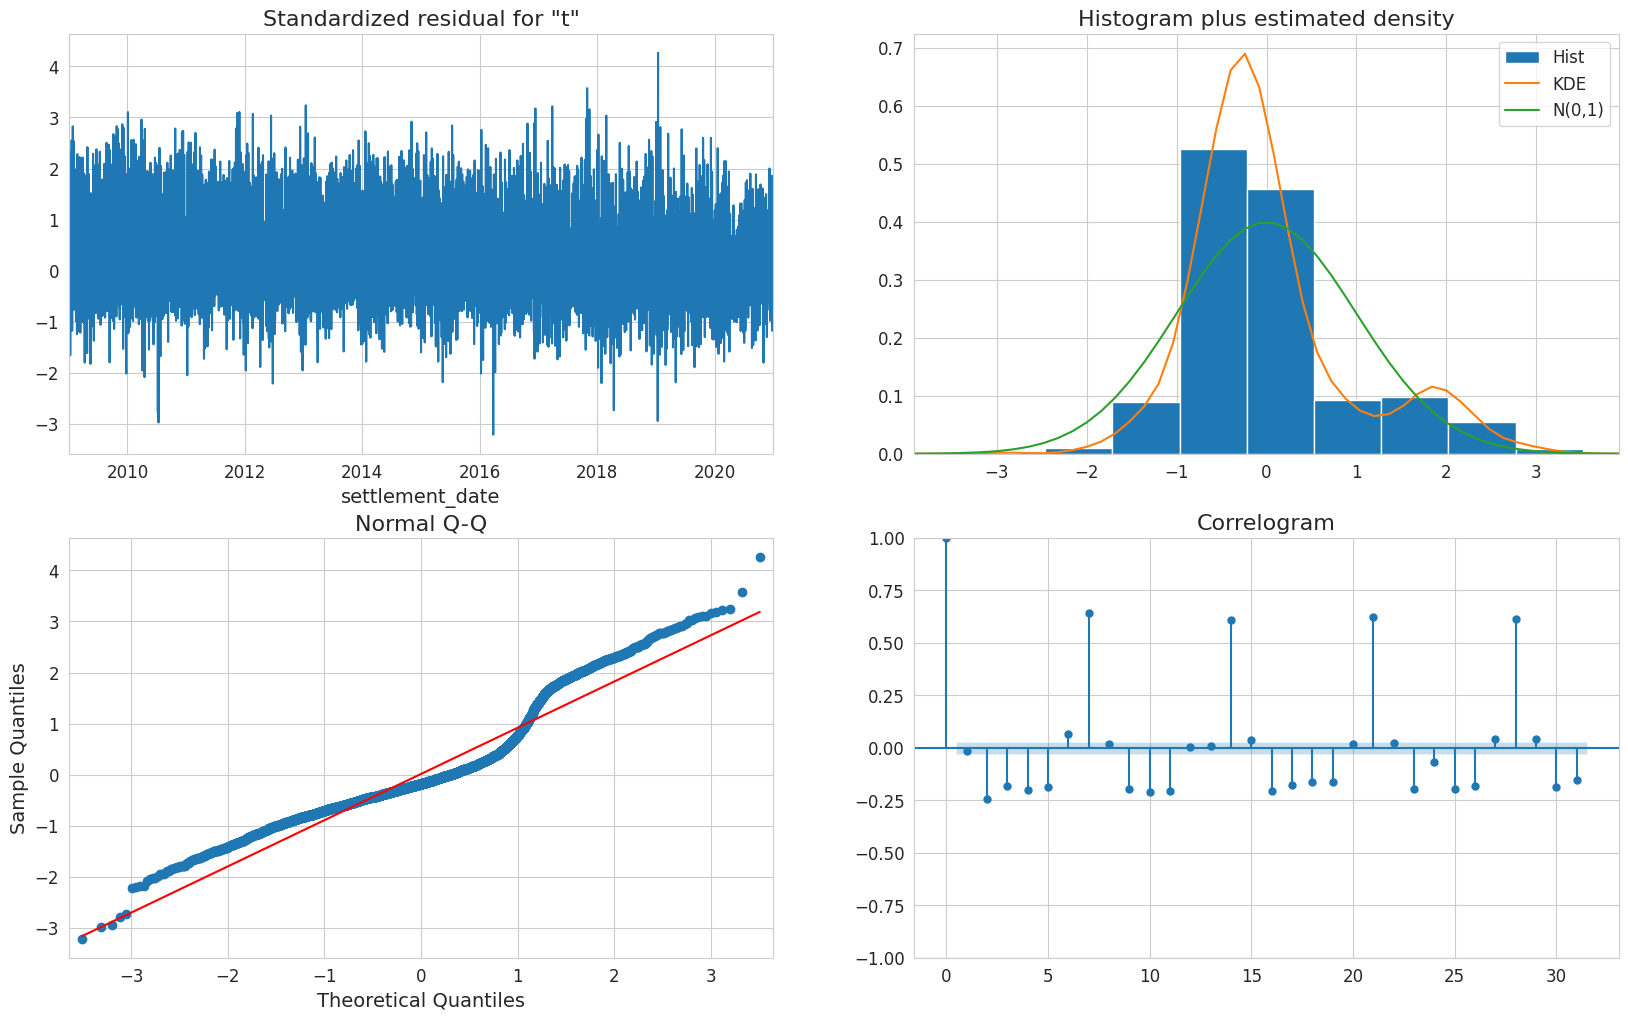

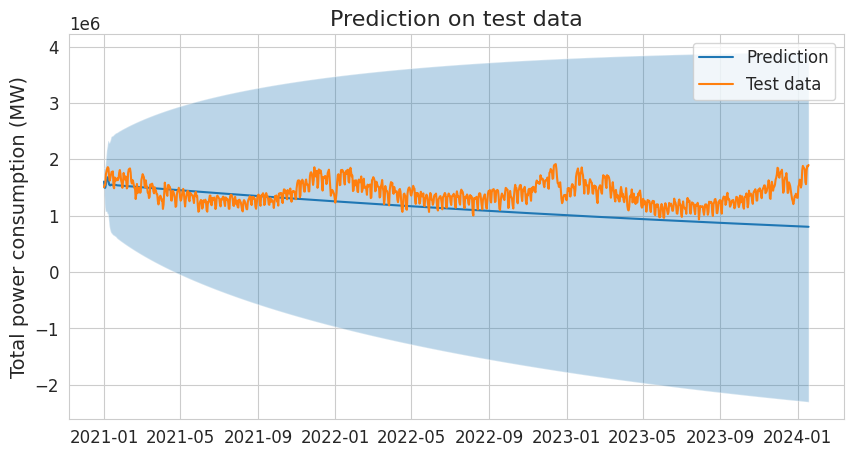

In [53]:
[execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
    train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
)

In [55]:
print(f"Model 0 MAPE value: {mape_0}")
print(f"Model 0 runtime: {execution_time_0}")

Model 0 MAPE value: 20.982507179464093
Model 0 runtime: 0:00:18.594252


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Normality: val=1754.684, p=0.000
Ljung-Box: val=513.530, p=0.000
Heteroskedasticity: val=0.964, p=0.486
Durbin-Watson: d=2.04
-------------------------------------------------------------


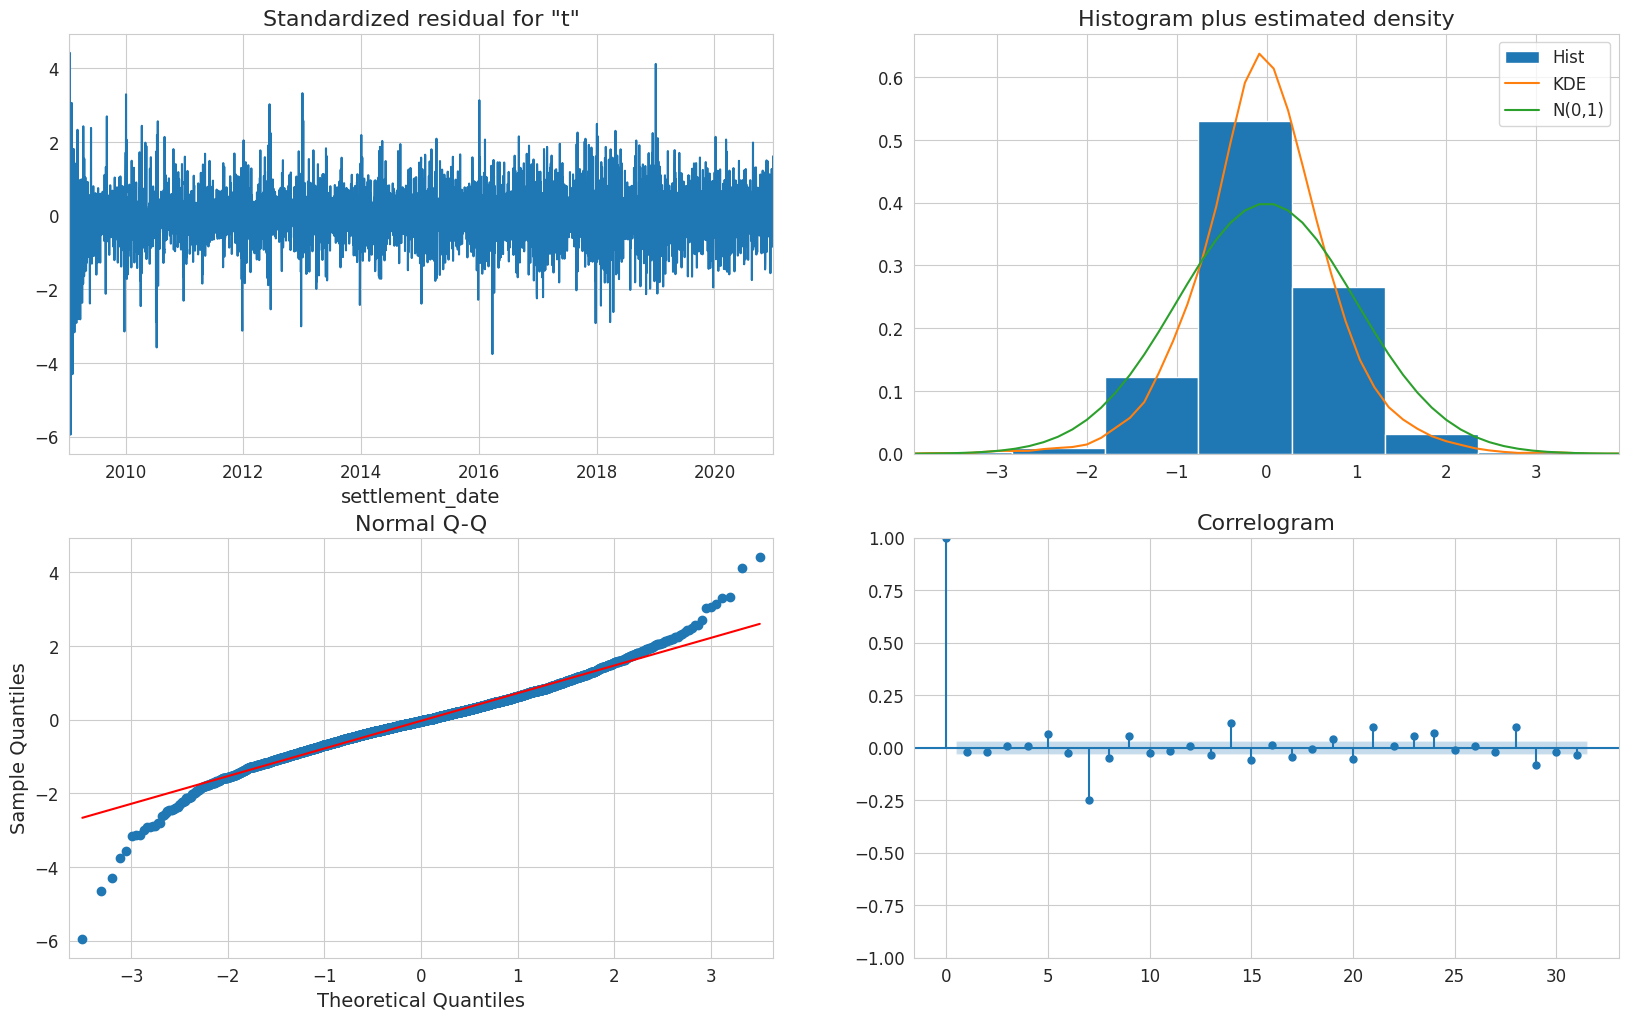

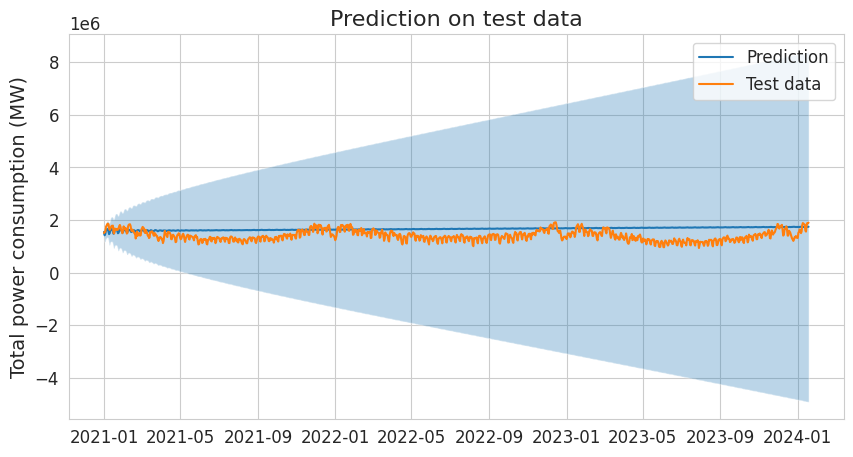

In [56]:
[execution_time_1, mape_1, sarima_model_1] = create_predict_analyse(
    train_data, (7, 1, 2), (3, 1, 2, 12), 50, 31, test_data, False
)

In [58]:
print(f"Model 0 MAPE value: {mape_1}")
print(f"Model 0 runtime: {execution_time_1}")

Model 0 MAPE value: 22.47433228030851
Model 0 runtime: 0:05:42.931292


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Normality: val=929.381, p=0.000
Ljung-Box: val=891.159, p=0.000
Heteroskedasticity: val=1.012, p=0.819
Durbin-Watson: d=2.28
-------------------------------------------------------------


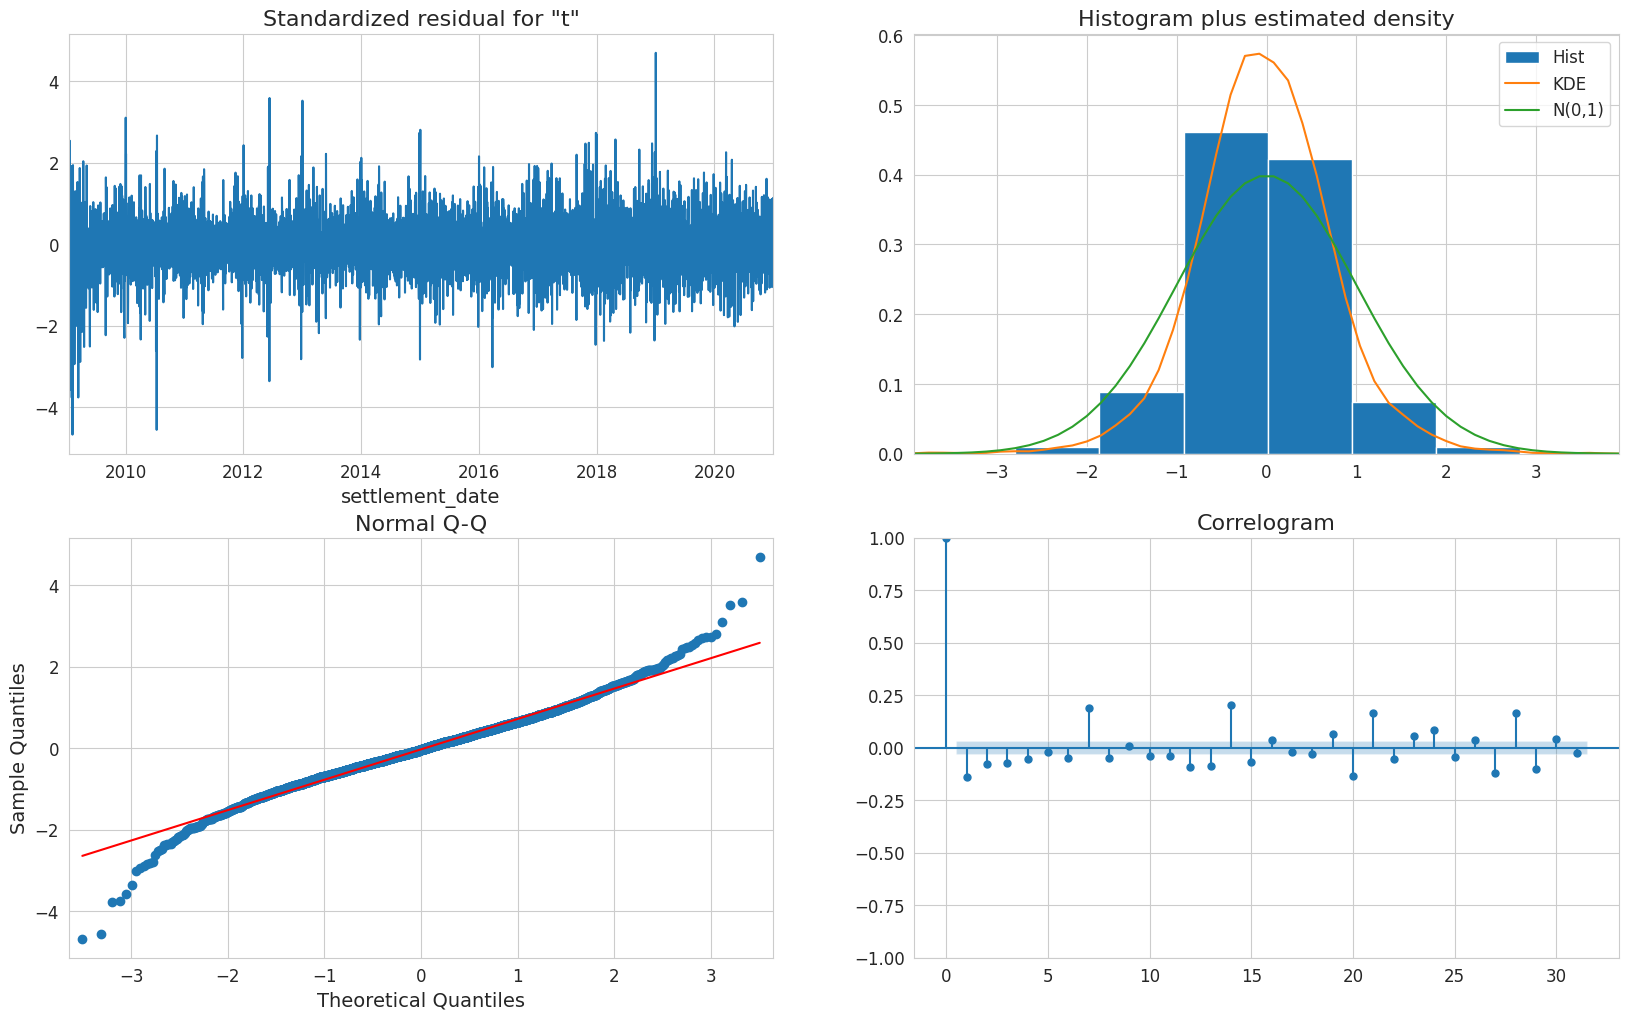

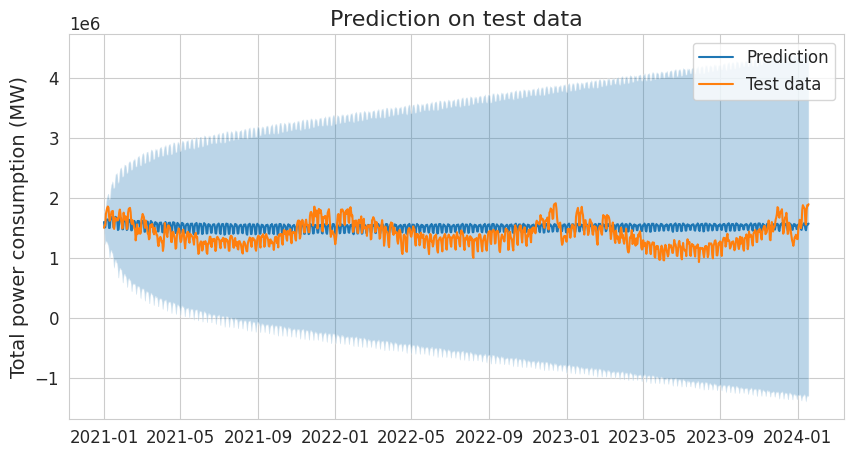

In [59]:
[execution_time_2, mape_2, sarima_model_2] = create_predict_analyse(
    train_data, (7, 1, 7), (3, 1, 2, 12), 50, 31, test_data, False
)

In [60]:
print(f"Model 0 MAPE value: {mape_2}")
print(f"Model 0 runtime: {execution_time_2}")

Model 0 MAPE value: 14.117132348397938
Model 0 runtime: 0:07:15.363129


**LSTM**

In [61]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

In [72]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [73]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

In [74]:
# Define a random seed for reproducibility
tf.random.set_seed(221)

# Create and compite neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "./models_data/simple_lstm/checkpoint",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

Epoch 1/100
1263/1263 [==============================] - ETA: 0s - loss: 0.1309

1263/1263 [==============================] - 49s 30ms/step - loss: 0.1309 - val_loss: 0.0975 - lr: 0.0010
Epoch 2/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.1054

1263/1263 [==============================] - 25s 20ms/step - loss: 0.1054 - val_loss: 0.0915 - lr: 0.0010
Epoch 3/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0985

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0985 - val_loss: 0.0883 - lr: 0.0010
Epoch 4/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0943

1263/1263 [==============================] - 31s 24ms/step - loss: 0.0943 - val_loss: 0.0888 - lr: 0.0010
Epoch 5/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0913

1263/1263 [==============================] - 25s 19ms/step - loss: 0.0913 - val_loss: 0.0837 - lr: 0.0010
Epoch 6/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0892

1263/1263 [==============================] - 22s 18ms/step - loss: 0.0892 - val_loss: 0.0823 - lr: 0.0010
Epoch 7/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0877

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0877 - val_loss: 0.0807 - lr: 0.0010
Epoch 8/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0865

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0865 - val_loss: 0.0806 - lr: 0.0010
Epoch 9/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0859

1263/1263 [==============================] - 23s 19ms/step - loss: 0.0859 - val_loss: 0.0795 - lr: 0.0010
Epoch 10/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0849

1263/1263 [==============================] - 22s 18ms/step - loss: 0.0849 - val_loss: 0.0803 - lr: 0.0010
Epoch 11/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0841

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0841 - val_loss: 0.0794 - lr: 0.0010
Epoch 12/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0836

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0836 - val_loss: 0.0787 - lr: 0.0010
Epoch 13/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0833

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0833 - val_loss: 0.0791 - lr: 0.0010
Epoch 14/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0829

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0829 - val_loss: 0.0778 - lr: 0.0010
Epoch 15/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0825

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0825 - val_loss: 0.0790 - lr: 0.0010
Epoch 16/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0823

1263/1263 [==============================] - 26s 21ms/step - loss: 0.0823 - val_loss: 0.0796 - lr: 0.0010
Epoch 17/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0820

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0820 - val_loss: 0.0773 - lr: 0.0010
Epoch 18/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0819

1263/1263 [==============================] - 23s 19ms/step - loss: 0.0819 - val_loss: 0.0781 - lr: 0.0010
Epoch 19/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0816

1263/1263 [==============================] - 22s 17ms/step - loss: 0.0816 - val_loss: 0.0766 - lr: 0.0010
Epoch 20/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0815

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0815 - val_loss: 0.0772 - lr: 0.0010
Epoch 21/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0812

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0812 - val_loss: 0.0767 - lr: 0.0010
Epoch 22/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0811

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0811 - val_loss: 0.0759 - lr: 0.0010
Epoch 23/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0809

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0809 - val_loss: 0.0767 - lr: 0.0010
Epoch 24/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0807

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0807 - val_loss: 0.0770 - lr: 0.0010
Epoch 25/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0807

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0807 - val_loss: 0.0755 - lr: 0.0010
Epoch 26/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0805

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0805 - val_loss: 0.0763 - lr: 0.0010
Epoch 27/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0803

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0803 - val_loss: 0.0753 - lr: 0.0010
Epoch 28/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0802

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0802 - val_loss: 0.0757 - lr: 0.0010
Epoch 29/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0801

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0801 - val_loss: 0.0753 - lr: 0.0010
Epoch 30/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0801

1263/1263 [==============================] - 26s 21ms/step - loss: 0.0801 - val_loss: 0.0748 - lr: 0.0010
Epoch 31/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0799

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0799 - val_loss: 0.0750 - lr: 0.0010
Epoch 32/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0796

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0796 - val_loss: 0.0748 - lr: 0.0010
Epoch 33/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0797

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0797 - val_loss: 0.0747 - lr: 0.0010
Epoch 34/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0795

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0795 - val_loss: 0.0756 - lr: 0.0010
Epoch 35/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0794

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0794 - val_loss: 0.0747 - lr: 0.0010
Epoch 36/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0792

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0792 - val_loss: 0.0749 - lr: 0.0010
Epoch 37/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0791

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0791 - val_loss: 0.0738 - lr: 0.0010
Epoch 38/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0789

1263/1263 [==============================] - 23s 19ms/step - loss: 0.0790 - val_loss: 0.0742 - lr: 0.0010
Epoch 39/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0787

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0787 - val_loss: 0.0740 - lr: 0.0010
Epoch 40/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0787

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0787 - val_loss: 0.0739 - lr: 0.0010
Epoch 41/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0786

1263/1263 [==============================] - 25s 19ms/step - loss: 0.0786 - val_loss: 0.0738 - lr: 0.0010
Epoch 42/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0781

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0781 - val_loss: 0.0734 - lr: 0.0010
Epoch 43/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0781

1263/1263 [==============================] - 23s 19ms/step - loss: 0.0781 - val_loss: 0.0735 - lr: 0.0010
Epoch 44/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0779

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0778 - val_loss: 0.0736 - lr: 0.0010
Epoch 45/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0778

1263/1263 [==============================] - 26s 21ms/step - loss: 0.0778 - val_loss: 0.0726 - lr: 0.0010
Epoch 46/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0774

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0774 - val_loss: 0.0729 - lr: 0.0010
Epoch 47/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0770

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0770 - val_loss: 0.0724 - lr: 0.0010
Epoch 48/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0768

1263/1263 [==============================] - 23s 19ms/step - loss: 0.0768 - val_loss: 0.0716 - lr: 0.0010
Epoch 49/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0764

1263/1263 [==============================] - 25s 19ms/step - loss: 0.0764 - val_loss: 0.0719 - lr: 0.0010
Epoch 50/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0761

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0761 - val_loss: 0.0714 - lr: 0.0010
Epoch 51/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0755

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0755 - val_loss: 0.0707 - lr: 0.0010
Epoch 52/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0750

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0750 - val_loss: 0.0719 - lr: 0.0010
Epoch 53/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0744

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0744 - val_loss: 0.0693 - lr: 0.0010
Epoch 54/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0740

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0740 - val_loss: 0.0700 - lr: 0.0010
Epoch 55/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0732

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0732 - val_loss: 0.0697 - lr: 0.0010
Epoch 56/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0728

1263/1263 [==============================] - 23s 19ms/step - loss: 0.0728 - val_loss: 0.0681 - lr: 0.0010
Epoch 57/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0723

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0723 - val_loss: 0.0672 - lr: 0.0010
Epoch 58/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0718

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0718 - val_loss: 0.0672 - lr: 0.0010
Epoch 59/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0711

1263/1263 [==============================] - 26s 20ms/step - loss: 0.0711 - val_loss: 0.0675 - lr: 0.0010
Epoch 60/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0707

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0707 - val_loss: 0.0669 - lr: 0.0010
Epoch 61/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0702

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0702 - val_loss: 0.0677 - lr: 0.0010
Epoch 62/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0696

1263/1263 [==============================] - 23s 19ms/step - loss: 0.0696 - val_loss: 0.0660 - lr: 0.0010
Epoch 63/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0692

1263/1263 [==============================] - 22s 17ms/step - loss: 0.0692 - val_loss: 0.0659 - lr: 0.0010
Epoch 64/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0688

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0688 - val_loss: 0.0650 - lr: 0.0010
Epoch 65/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0684

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0684 - val_loss: 0.0657 - lr: 0.0010
Epoch 66/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0680

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0680 - val_loss: 0.0649 - lr: 0.0010
Epoch 67/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0677

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0677 - val_loss: 0.0656 - lr: 0.0010
Epoch 68/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0676

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0676 - val_loss: 0.0655 - lr: 0.0010
Epoch 69/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0672

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0671 - val_loss: 0.0637 - lr: 0.0010
Epoch 70/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0670

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0670 - val_loss: 0.0636 - lr: 0.0010
Epoch 71/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0667

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0667 - val_loss: 0.0645 - lr: 0.0010
Epoch 72/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0663

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0663 - val_loss: 0.0639 - lr: 0.0010
Epoch 73/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0662

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0662 - val_loss: 0.0644 - lr: 0.0010
Epoch 74/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0661

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0661 - val_loss: 0.0631 - lr: 0.0010
Epoch 75/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0658

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0658 - val_loss: 0.0622 - lr: 0.0010
Epoch 76/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0656

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0656 - val_loss: 0.0629 - lr: 0.0010
Epoch 77/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0655

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0655 - val_loss: 0.0633 - lr: 0.0010
Epoch 78/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0653

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0653 - val_loss: 0.0621 - lr: 0.0010
Epoch 79/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0651

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0651 - val_loss: 0.0632 - lr: 0.0010
Epoch 80/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0648

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0648 - val_loss: 0.0631 - lr: 0.0010
Epoch 81/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0649

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0649 - val_loss: 0.0621 - lr: 0.0010
Epoch 82/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0646

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0646 - val_loss: 0.0633 - lr: 0.0010
Epoch 83/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0645

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0645 - val_loss: 0.0615 - lr: 0.0010
Epoch 84/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0644

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0644 - val_loss: 0.0623 - lr: 0.0010
Epoch 85/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0643

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0643 - val_loss: 0.0631 - lr: 0.0010
Epoch 86/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0640

1263/1263 [==============================] - 26s 20ms/step - loss: 0.0640 - val_loss: 0.0617 - lr: 0.0010
Epoch 87/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0641

1263/1263 [==============================] - 26s 20ms/step - loss: 0.0641 - val_loss: 0.0620 - lr: 0.0010
Epoch 88/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0638

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0638 - val_loss: 0.0616 - lr: 0.0010
Epoch 89/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0636

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0636 - val_loss: 0.0618 - lr: 0.0010
Epoch 90/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0636

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0636 - val_loss: 0.0640 - lr: 0.0010
Epoch 91/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0635

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0635 - val_loss: 0.0629 - lr: 0.0010
Epoch 92/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0634

1263/1263 [==============================] - 23s 18ms/step - loss: 0.0634 - val_loss: 0.0631 - lr: 0.0010
Epoch 93/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0633

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0633 - val_loss: 0.0620 - lr: 0.0010
Epoch 94/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0632

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0632 - val_loss: 0.0609 - lr: 0.0010
Epoch 95/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0631

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0631 - val_loss: 0.0622 - lr: 0.0010
Epoch 96/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0630

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0630 - val_loss: 0.0616 - lr: 0.0010
Epoch 97/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0627

1263/1263 [==============================] - 24s 19ms/step - loss: 0.0627 - val_loss: 0.0614 - lr: 0.0010
Epoch 98/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0628

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0628 - val_loss: 0.0606 - lr: 0.0010
Epoch 99/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0627

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0627 - val_loss: 0.0621 - lr: 0.0010
Epoch 100/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0625

1263/1263 [==============================] - 25s 20ms/step - loss: 0.0625 - val_loss: 0.0614 - lr: 0.0010


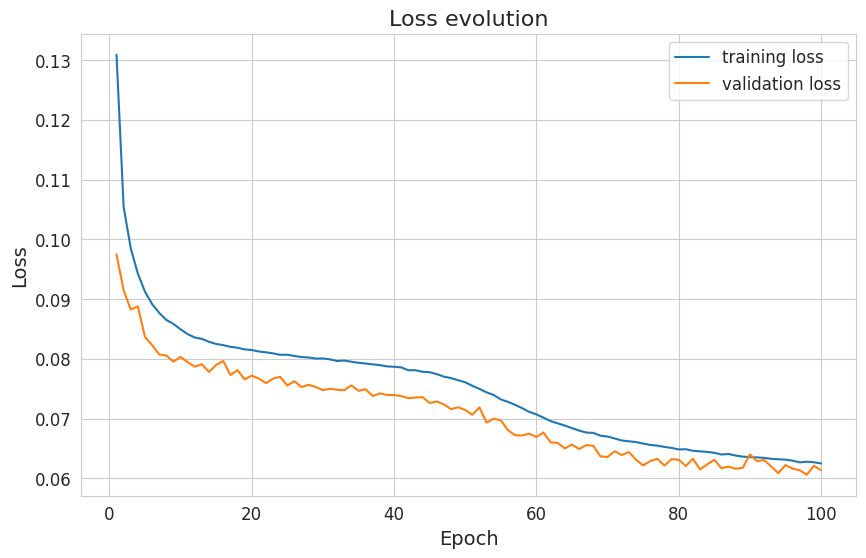

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

In [76]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_lstm"] = results_lstm[:,-1]


1097/1097 [==============================] - 9s 7ms/step


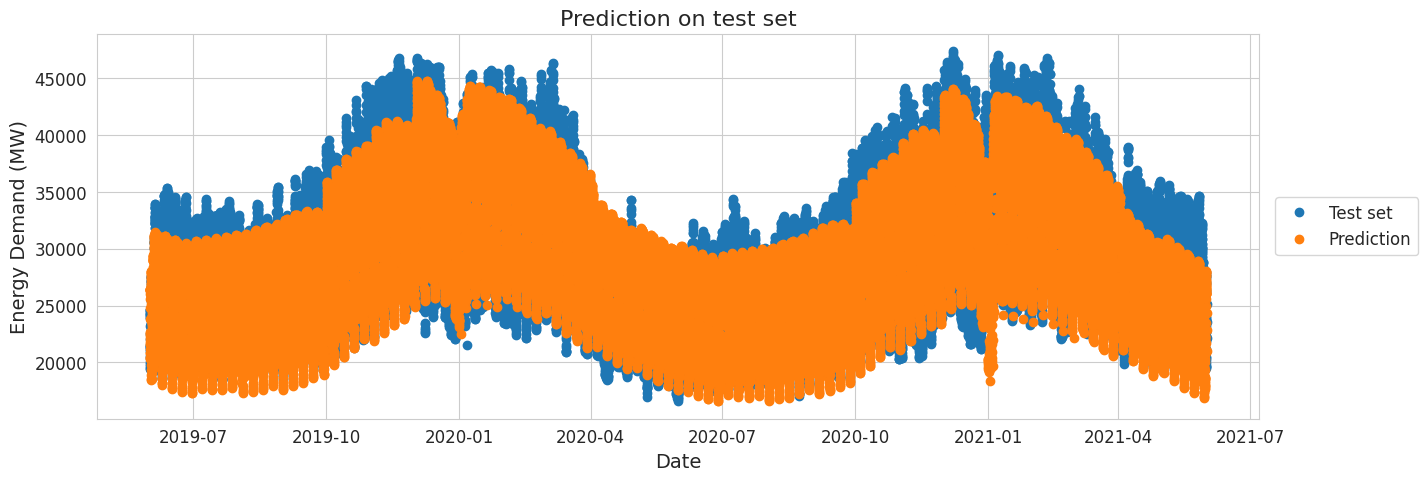

In [77]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

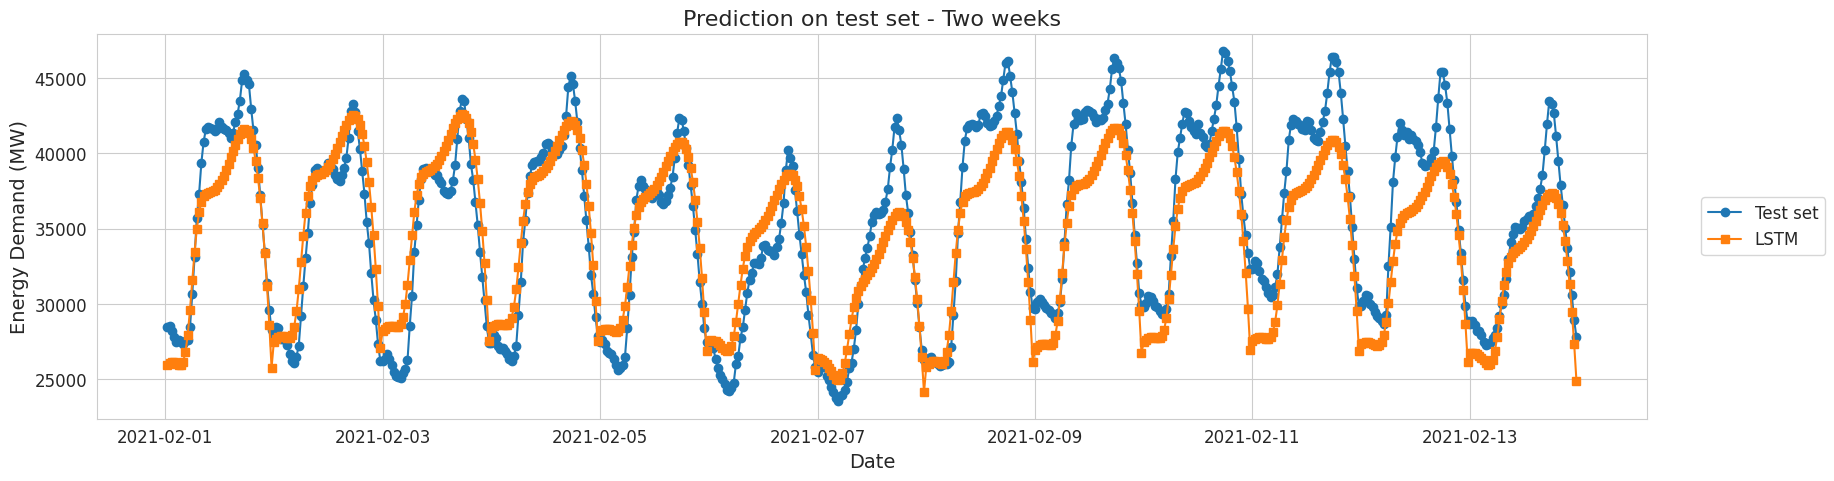

In [78]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [79]:
mape_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_lstm"]
)

rmse_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_lstm"]))

print(
    "Mean Absolute Percentage Error of the LSTM model is: %.2f" % mape_lstm
)

print(
    "Root Mean Squared Error of the LSTM model is: %.2f MW" % rmse_lstm
)

Mean Absolute Percentage Error of the LSTM model is: 7.54
Root Mean Squared Error of the LSTM model is: 2755.84 MW


 **Deep LSTM**

In [80]:
# Create and compile neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "./models_data/deep_lstm/checkpoint",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history_deep_lstm = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

Epoch 1/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.1366

1263/1263 [==============================] - 51s 33ms/step - loss: 0.1366 - val_loss: 0.0698 - lr: 0.0010
Epoch 2/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0970

1263/1263 [==============================] - 40s 31ms/step - loss: 0.0970 - val_loss: 0.0581 - lr: 0.0010
Epoch 3/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0880

1263/1263 [==============================] - 39s 31ms/step - loss: 0.0880 - val_loss: 0.0470 - lr: 0.0010
Epoch 4/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0808

1263/1263 [==============================] - 41s 32ms/step - loss: 0.0808 - val_loss: 0.0444 - lr: 0.0010
Epoch 5/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0772

1263/1263 [==============================] - 42s 33ms/step - loss: 0.0772 - val_loss: 0.0371 - lr: 0.0010
Epoch 6/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0752

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0752 - val_loss: 0.0387 - lr: 0.0010
Epoch 7/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0737

1263/1263 [==============================] - 37s 29ms/step - loss: 0.0737 - val_loss: 0.0314 - lr: 0.0010
Epoch 8/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0730

1263/1263 [==============================] - 37s 30ms/step - loss: 0.0730 - val_loss: 0.0308 - lr: 0.0010
Epoch 9/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0724

1263/1263 [==============================] - 37s 29ms/step - loss: 0.0724 - val_loss: 0.0290 - lr: 0.0010
Epoch 10/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0716

1263/1263 [==============================] - 39s 31ms/step - loss: 0.0716 - val_loss: 0.0278 - lr: 0.0010
Epoch 11/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0709

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0709 - val_loss: 0.0325 - lr: 0.0010
Epoch 12/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0706

1263/1263 [==============================] - 37s 30ms/step - loss: 0.0706 - val_loss: 0.0320 - lr: 0.0010
Epoch 13/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0701

1263/1263 [==============================] - 40s 32ms/step - loss: 0.0701 - val_loss: 0.0325 - lr: 0.0010
Epoch 14/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0694

1263/1263 [==============================] - 39s 31ms/step - loss: 0.0694 - val_loss: 0.0335 - lr: 0.0010
Epoch 15/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0691

1263/1263 [==============================] - 37s 30ms/step - loss: 0.0691 - val_loss: 0.0337 - lr: 0.0010
Epoch 16/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0684

1263/1263 [==============================] - 39s 31ms/step - loss: 0.0684 - val_loss: 0.0316 - lr: 0.0010
Epoch 17/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0675

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0675 - val_loss: 0.0308 - lr: 0.0010
Epoch 18/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0670

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0670 - val_loss: 0.0287 - lr: 0.0010
Epoch 19/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0664

1263/1263 [==============================] - 37s 29ms/step - loss: 0.0664 - val_loss: 0.0331 - lr: 0.0010
Epoch 20/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0657

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0657 - val_loss: 0.0378 - lr: 0.0010
Epoch 21/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0654

1263/1263 [==============================] - 37s 29ms/step - loss: 0.0654 - val_loss: 0.0401 - lr: 0.0010
Epoch 22/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0651

1263/1263 [==============================] - 40s 32ms/step - loss: 0.0651 - val_loss: 0.0398 - lr: 0.0010
Epoch 23/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0644

1263/1263 [==============================] - 39s 31ms/step - loss: 0.0644 - val_loss: 0.0381 - lr: 0.0010
Epoch 24/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0643

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0643 - val_loss: 0.0366 - lr: 0.0010
Epoch 25/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0638

1263/1263 [==============================] - 39s 31ms/step - loss: 0.0638 - val_loss: 0.0422 - lr: 0.0010
Epoch 26/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0637

1263/1263 [==============================] - 40s 32ms/step - loss: 0.0637 - val_loss: 0.0394 - lr: 0.0010
Epoch 27/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0633

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0633 - val_loss: 0.0375 - lr: 0.0010
Epoch 28/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0631

1263/1263 [==============================] - 36s 28ms/step - loss: 0.0631 - val_loss: 0.0363 - lr: 0.0010
Epoch 29/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0629

1263/1263 [==============================] - 36s 29ms/step - loss: 0.0629 - val_loss: 0.0439 - lr: 0.0010
Epoch 30/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0626

1263/1263 [==============================] - 40s 31ms/step - loss: 0.0626 - val_loss: 0.0422 - lr: 0.0010
Epoch 31/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0626

1263/1263 [==============================] - 39s 31ms/step - loss: 0.0626 - val_loss: 0.0422 - lr: 0.0010
Epoch 32/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0622

1263/1263 [==============================] - 37s 30ms/step - loss: 0.0622 - val_loss: 0.0418 - lr: 0.0010
Epoch 33/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0621

1263/1263 [==============================] - 37s 29ms/step - loss: 0.0621 - val_loss: 0.0417 - lr: 0.0010
Epoch 34/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0620

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0620 - val_loss: 0.0378 - lr: 0.0010
Epoch 35/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0618

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0618 - val_loss: 0.0391 - lr: 0.0010
Epoch 36/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0617

1263/1263 [==============================] - 33s 26ms/step - loss: 0.0617 - val_loss: 0.0383 - lr: 0.0010
Epoch 37/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0614

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0614 - val_loss: 0.0426 - lr: 0.0010
Epoch 38/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0612

1263/1263 [==============================] - 33s 26ms/step - loss: 0.0612 - val_loss: 0.0376 - lr: 0.0010
Epoch 39/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0612

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0612 - val_loss: 0.0449 - lr: 0.0010
Epoch 40/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0610

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0610 - val_loss: 0.0397 - lr: 0.0010
Epoch 41/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0610

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0610 - val_loss: 0.0417 - lr: 0.0010
Epoch 42/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0606

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0606 - val_loss: 0.0414 - lr: 0.0010
Epoch 43/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0607

1263/1263 [==============================] - 33s 26ms/step - loss: 0.0607 - val_loss: 0.0431 - lr: 0.0010
Epoch 44/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0603

1263/1263 [==============================] - 35s 27ms/step - loss: 0.0603 - val_loss: 0.0396 - lr: 0.0010
Epoch 45/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0603

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0603 - val_loss: 0.0371 - lr: 0.0010
Epoch 46/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0601

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0601 - val_loss: 0.0385 - lr: 0.0010
Epoch 47/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0602

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0602 - val_loss: 0.0349 - lr: 0.0010
Epoch 48/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0599

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0599 - val_loss: 0.0429 - lr: 0.0010
Epoch 49/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0598

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0598 - val_loss: 0.0422 - lr: 0.0010
Epoch 50/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0597

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0597 - val_loss: 0.0412 - lr: 0.0010
Epoch 51/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0595

1263/1263 [==============================] - 36s 29ms/step - loss: 0.0595 - val_loss: 0.0379 - lr: 0.0010
Epoch 52/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0595

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0595 - val_loss: 0.0430 - lr: 0.0010
Epoch 53/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0593

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0593 - val_loss: 0.0417 - lr: 0.0010
Epoch 54/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0594

1263/1263 [==============================] - 35s 27ms/step - loss: 0.0594 - val_loss: 0.0424 - lr: 0.0010
Epoch 55/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0591

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0591 - val_loss: 0.0402 - lr: 0.0010
Epoch 56/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0591

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0591 - val_loss: 0.0421 - lr: 0.0010
Epoch 57/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0590

1263/1263 [==============================] - 36s 29ms/step - loss: 0.0590 - val_loss: 0.0380 - lr: 0.0010
Epoch 58/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0590

1263/1263 [==============================] - 36s 28ms/step - loss: 0.0590 - val_loss: 0.0393 - lr: 0.0010
Epoch 59/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0587

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0587 - val_loss: 0.0365 - lr: 0.0010
Epoch 60/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0589

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0589 - val_loss: 0.0408 - lr: 0.0010
Epoch 61/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0586

1263/1263 [==============================] - 36s 29ms/step - loss: 0.0586 - val_loss: 0.0396 - lr: 0.0010
Epoch 62/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0586

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0586 - val_loss: 0.0382 - lr: 0.0010
Epoch 63/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0585

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0585 - val_loss: 0.0402 - lr: 0.0010
Epoch 64/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0585

1263/1263 [==============================] - 33s 27ms/step - loss: 0.0585 - val_loss: 0.0418 - lr: 0.0010
Epoch 65/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0583

1263/1263 [==============================] - 36s 28ms/step - loss: 0.0583 - val_loss: 0.0402 - lr: 0.0010
Epoch 66/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0582

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0582 - val_loss: 0.0385 - lr: 0.0010
Epoch 67/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0582

1263/1263 [==============================] - 35s 27ms/step - loss: 0.0582 - val_loss: 0.0402 - lr: 0.0010
Epoch 68/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0582

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0582 - val_loss: 0.0404 - lr: 0.0010
Epoch 69/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0581

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0581 - val_loss: 0.0411 - lr: 0.0010
Epoch 70/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0581

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0581 - val_loss: 0.0400 - lr: 0.0010
Epoch 71/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0580

1263/1263 [==============================] - 36s 29ms/step - loss: 0.0580 - val_loss: 0.0431 - lr: 0.0010
Epoch 72/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0579

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0579 - val_loss: 0.0387 - lr: 0.0010
Epoch 73/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0580

1263/1263 [==============================] - 36s 29ms/step - loss: 0.0580 - val_loss: 0.0401 - lr: 0.0010
Epoch 74/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0579

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0579 - val_loss: 0.0407 - lr: 0.0010
Epoch 75/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0580

1263/1263 [==============================] - 36s 28ms/step - loss: 0.0580 - val_loss: 0.0398 - lr: 0.0010
Epoch 76/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0576

1263/1263 [==============================] - 37s 29ms/step - loss: 0.0576 - val_loss: 0.0389 - lr: 0.0010
Epoch 77/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0578

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0578 - val_loss: 0.0443 - lr: 0.0010
Epoch 78/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0575

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0575 - val_loss: 0.0414 - lr: 0.0010
Epoch 79/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0577

1263/1263 [==============================] - 41s 32ms/step - loss: 0.0577 - val_loss: 0.0405 - lr: 0.0010
Epoch 80/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0575

1263/1263 [==============================] - 39s 31ms/step - loss: 0.0575 - val_loss: 0.0437 - lr: 0.0010
Epoch 81/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0574

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0573 - val_loss: 0.0433 - lr: 0.0010
Epoch 82/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0576

1263/1263 [==============================] - 38s 30ms/step - loss: 0.0576 - val_loss: 0.0437 - lr: 0.0010
Epoch 83/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0574

1263/1263 [==============================] - 33s 26ms/step - loss: 0.0574 - val_loss: 0.0431 - lr: 0.0010
Epoch 84/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0574

1263/1263 [==============================] - 36s 28ms/step - loss: 0.0574 - val_loss: 0.0437 - lr: 0.0010
Epoch 85/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0574

1263/1263 [==============================] - 37s 29ms/step - loss: 0.0574 - val_loss: 0.0437 - lr: 0.0010
Epoch 86/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0573

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0573 - val_loss: 0.0408 - lr: 0.0010
Epoch 87/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0573

1263/1263 [==============================] - 36s 29ms/step - loss: 0.0573 - val_loss: 0.0395 - lr: 0.0010
Epoch 88/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0571

1263/1263 [==============================] - 37s 29ms/step - loss: 0.0571 - val_loss: 0.0409 - lr: 0.0010
Epoch 89/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0572

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0572 - val_loss: 0.0461 - lr: 0.0010
Epoch 90/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0569

1263/1263 [==============================] - 36s 28ms/step - loss: 0.0569 - val_loss: 0.0438 - lr: 0.0010
Epoch 91/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0571

1263/1263 [==============================] - 35s 28ms/step - loss: 0.0571 - val_loss: 0.0407 - lr: 0.0010
Epoch 92/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0571

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0571 - val_loss: 0.0410 - lr: 0.0010
Epoch 93/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0570

1263/1263 [==============================] - 35s 27ms/step - loss: 0.0570 - val_loss: 0.0425 - lr: 0.0010
Epoch 94/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0571

1263/1263 [==============================] - 34s 27ms/step - loss: 0.0571 - val_loss: 0.0430 - lr: 0.0010
Epoch 95/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0566

1263/1263 [==============================] - 35s 27ms/step - loss: 0.0566 - val_loss: 0.0417 - lr: 0.0010
Epoch 96/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0569

1263/1263 [==============================] - 35s 27ms/step - loss: 0.0569 - val_loss: 0.0416 - lr: 0.0010
Epoch 97/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0567

1263/1263 [==============================] - 35s 27ms/step - loss: 0.0567 - val_loss: 0.0433 - lr: 0.0010
Epoch 98/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0568

1263/1263 [==============================] - 36s 29ms/step - loss: 0.0568 - val_loss: 0.0438 - lr: 0.0010
Epoch 99/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0566

1263/1263 [==============================] - 36s 28ms/step - loss: 0.0566 - val_loss: 0.0415 - lr: 0.0010
Epoch 100/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0569

1263/1263 [==============================] - 35s 27ms/step - loss: 0.0569 - val_loss: 0.0408 - lr: 0.0010


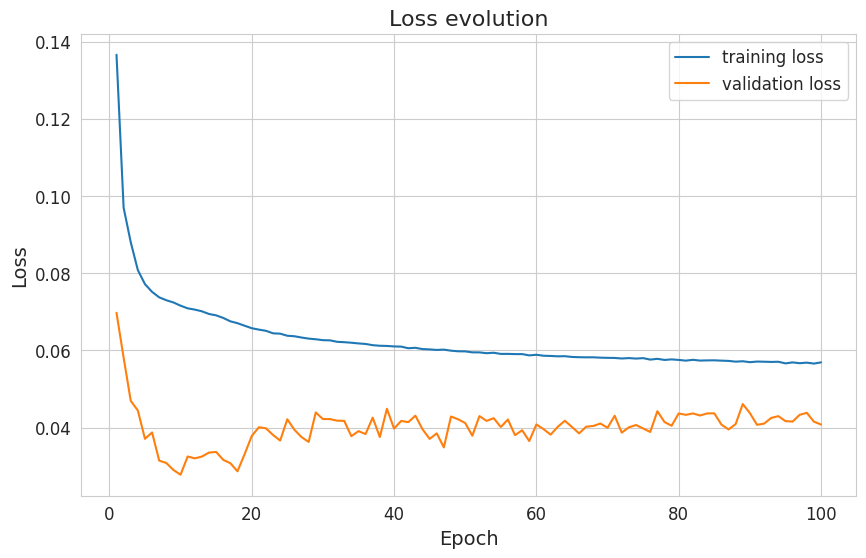

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

In [82]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_deep_lstm"] = results_deep_lstm[:,-1]

1097/1097 [==============================] - 14s 10ms/step


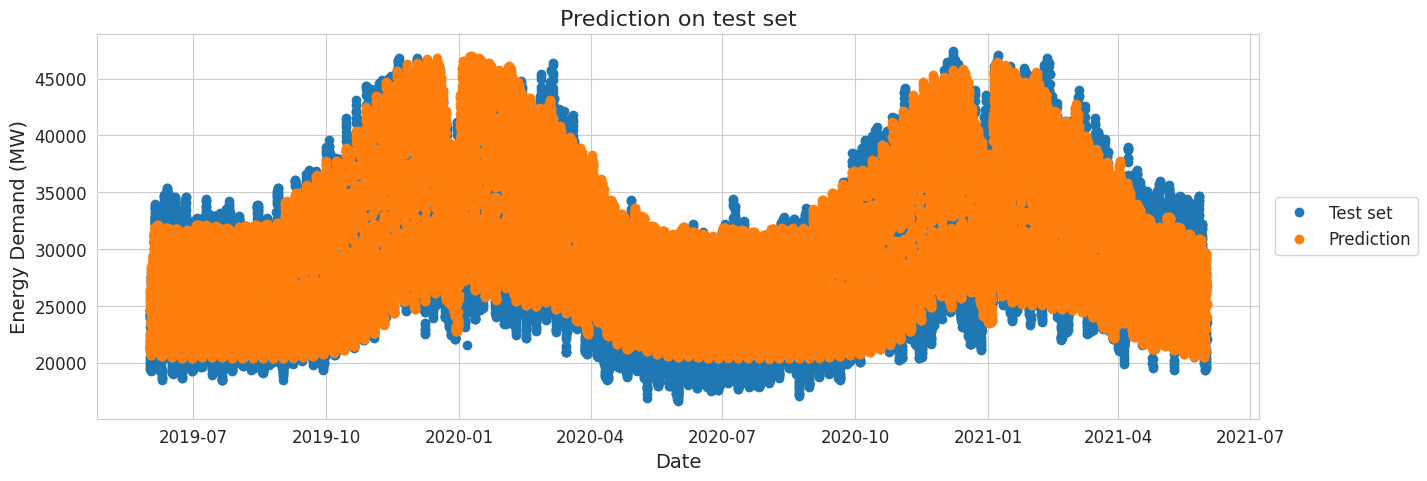

In [83]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

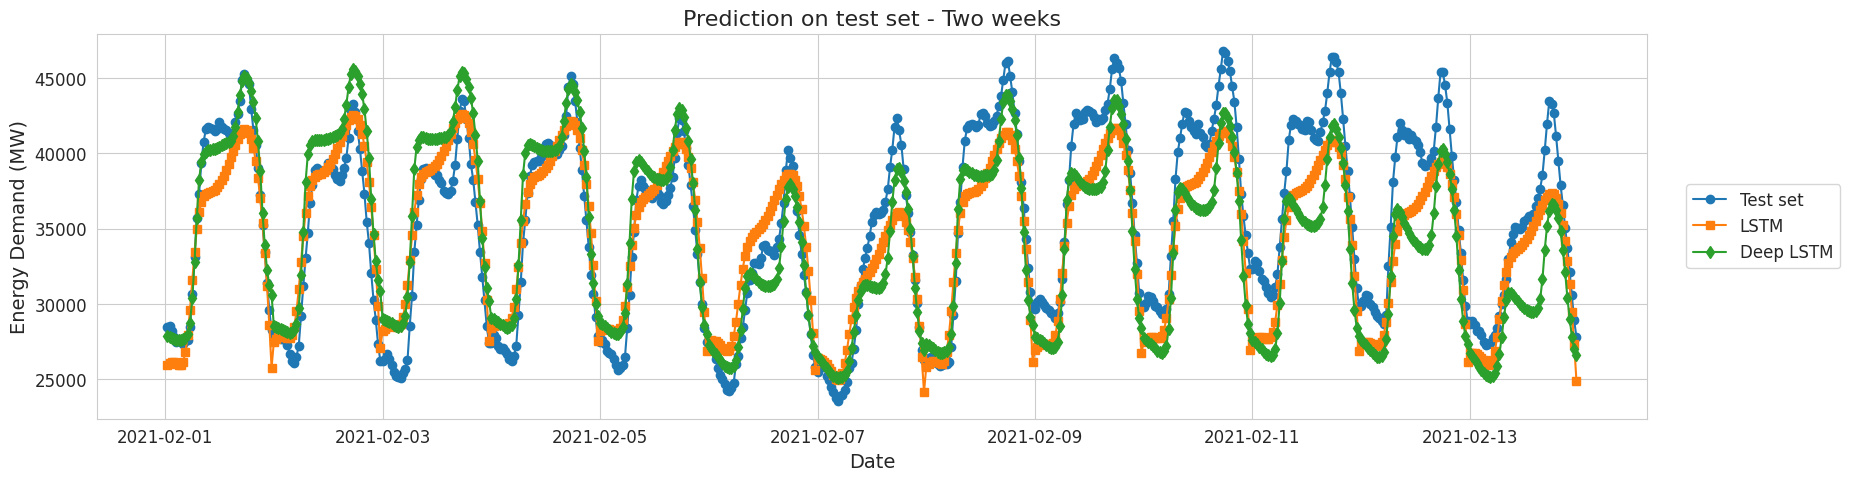

In [84]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="Deep LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [85]:
mape_deep_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_deep_lstm"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the deep LSTM model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the deep LSTM model is: %.2f MW" % rmse_deep_lstm
)

Mean Absolute Percentage Error of the deep LSTM model is: 7.25
Root Mean Squared Error of the deep LSTM model is: 2604.95 MW
